# SWMM LID Scenario automation for Meadow Creek

# Required Python Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pyswmm
from pyswmm import Simulation, LidControls, LidGroups, Subcatchments, Nodes
import os
import swmmio as sio

# SWMM Model Basin Specific Dictionaries 
## These dictionaries will be referenced throughout the code and used to calculate new parameters that accompany new LIDs in SWMM

### The following dictionares contain characteristics for each individual subbasin
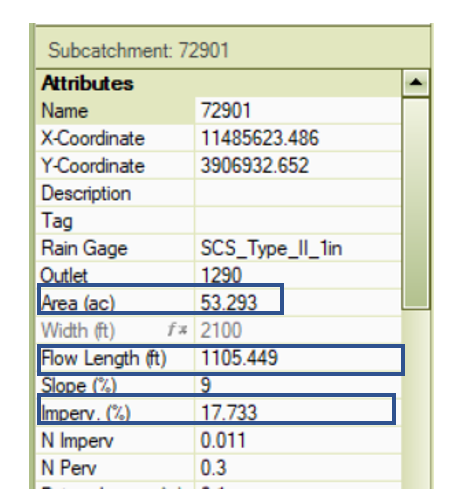
 

In [2]:
#Subbasin Characteristic Dictionaries
subbasin_areas = {'72591': 930398.04, '72631': 952047.36, '72671': 1011681.0, '72731': 954530.28, '72781': 1649965.68, '72951': 1785524.4, '73081': 1531569.6, '73121': 1481911.2, '73171': 677488.68, '73181': 626044.32, '73201': 922731.48, '73211': 1332718.2, '73301': 1379980.8, '73321': 629311.32, '73391': 762430.68, '73421': 672827.76, '73461': 708067.8, '73531': 677662.92, '73551': 603218.88, '73571': 368648.28}
subbasin_imperv_areas = {'72591': 230720.106, '72631': 418386.7328, '72671': 294287.8861, '72731': 506340.1323, '72781': 530480.4658, '72951': 419348.2606, '73081': 545667.6171, '73121': 717393.2119, '73171': 390782.2455, '73181': 431162.9836, '73201': 494805.5288, '73211': 431094.3562, '73301': 632569.3989, '73321': 437044.1255, '73391': 164067.458, '73421': 504230.5799, '73461': 532764.3741, '73531': 469972.7883, '73551': 412975.7096, '73571': 253029.1199}
subbasin_perv_areas = {'72591': 699677.934, '72631': 533660.6272, '72671': 717393.1139, '72731': 448190.1477, '72781': 1119485.214, '72951': 1366176.139, '73081': 985901.9829, '73121': 764517.9881, '73171': 286706.4345, '73181': 194881.3364, '73201': 427925.9512, '73211': 901623.8438, '73301': 747411.4011, '73321': 192267.1945, '73391': 598363.222, '73421': 168597.1801, '73461': 175303.4259, '73531': 207690.1317, '73551': 190243.1704, '73571': 115619.1601}
subbasin_flowlengths = {'72591': 1094.586, '72631': 793.373, '72671': 1445.259, '72731': 1272.707, '72781': 1833.295, '72951': 915.654, '73081': 957.231, '73121': 4234.032, '73171': 615.899, '73181': 2086.814, '73201': 1419.587, '73211': 1665.898, '73301': 2759.962, '73321': 968.171, '73391': 476.519, '73421': 480.591, '73461': 708.068, '73531': 1042.558, '73551': 928.029, '73571': 1053.281}

### The following dictionaries were manually calculated from spatial criteria derived from GIS data 
### Raster data was multiplied using matrix multipication to eliminate non-feasible locations for each LID off the map
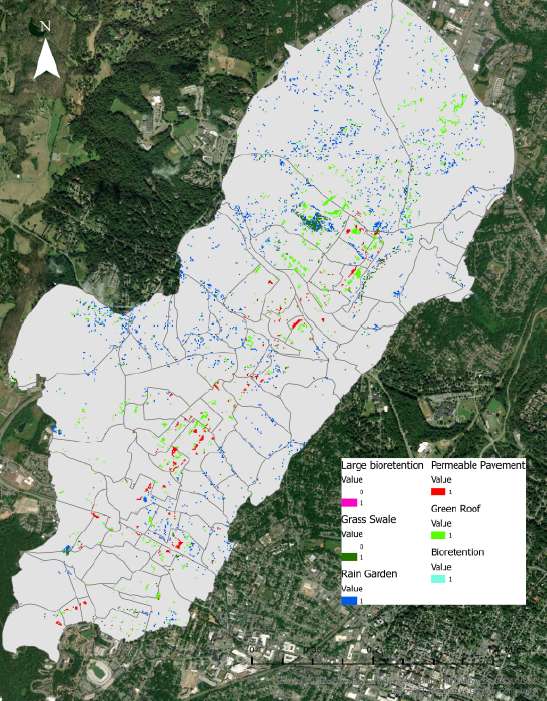

In [3]:
#Subbasin LID Feasble Area Dictionaries
raingarden_feasible_areas = {'72591': 55583.9368, '72631': 19815.3296, '72671': 44162.83, '72731': 21000.83666, '72781': 23024.24035, '72951': 43306.46711, '73081': 13920.64411, '73121': 23892.97048, '73171': 0.0, '73181': 3385.30813, '73201': 9353.089577, '73211': 12806.63365, '73301': 636.1767258, '73321': 671.0354, '73391': 9520.57, '73421': 0.0, '73461': 5787.304599, '73531': 20854.943, '73551': 11511.16, '73571': 8611.12}
permeablepavement_feasible_areas = {'72591': 0.0, '72631': 3592.054222, '72671': 0.0, '72731': 9935.438827, '72781': 12553.53077, '72951': 14386.89196, '73081': 9687.51, '73121': 12827.45501, '73171': 9776.734992, '73181': 7534.73, '73201': 30138.92, '73211': 1076.39, '73301': 17222.24, '73321': 6647.736192, '73391': 1076.39, '73421': 7345.333808, '73461': 25833.36, '73531': 32600.9754, '73551': 0.0, '73571': 20832.98346}
greenroof_feasible_areas = {'72591': 2152.78, '72631': 12921.38023, '72671': 1173.503467, '72731': 29062.53, '72781': 7534.73, '72951': 9687.51, '73081': 21384.84111, '73121': 9357.285313, '73171': 16289.43527, '73181': 6990.681118, '73201': 30615.11554, '73211': 1296.256317, '73301': 16630.5235, '73321': 26148.32693, '73391': 0.0, '73421': 20630.7033, '73461': 71257.33823, '73531': 52908.96152, '73551': 10049.59107, '73571': 37450.83357}
bioretention_feasible_areas = {'72591': 1076.39, '72631': 1076.39, '72671': 1076.39, '72731': 3229.17, '72781': 7.996802699, '72951': 1068.393197, '73081': 0.0, '73121': 5381.95, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 1076.39, '73421': 0.0, '73461': 0.0, '73531': 1076.39, '73551': 0.0, '73571': 4305.56}
grassswale_feasible_areas = {'73081': 7534.73, '72671': 0.0, '72591': 2152.78, '72631': 3229.17, '72781': 0.0, '72731': 0.0, '72951': 10763.9, '73211': 0.0, '73181': 0.0, '73171': 0.0, '73121': 2152.78, '73201': 0.0, '73301': 0.0, '73321': 0.0, '73391': 10096.5382, '73461': 0.0, '73421': 0.0, '73551': 0.0, '73531': 0.0, '73571': 5177.4359}


## The next dictionaries are standard select LID surface areas used to treat a standard drainage area. Raingarden, bioretention, and grassswale surface area requirements vary by subbasin based on runoff coefficients. 

In [4]:
#Other LID Dictionaries
raingarden_standard_surfaceareas = {'72591': 616.6014319, '72631': 871.622691, '72671': 699.6268099, '72731': 762.1321942, '72781': 695.4204566, '72951': 567.673537, '73081': 765.5796487, '73121': 816.0431198, '73171': 913.0600918, '73181': 1017.27915, '73201': 936.7333456, '73211': 598.6061559, '73301': 950.2543445, '73321': 1105.661561, '73391': 677.1456018, '73421': 1137.466808, '73461': 1138.968494, '73531': 1058.328457, '73551': 1058.44356, '73571': 1112.715481}
bioretention_standard_surfaceareas = {'72591': 3212.817987, '72631': 4541.612969, '72671': 3645.423904, '72731': 3971.109854, '72781': 3623.50659, '72951': 2957.877903, '73081': 3989.072906, '73121': 4252.014151, '73171': 4757.523636, '73181': 5300.559781, '73201': 4880.873748, '73211': 3119.053128, '73301': 4951.325269, '73321': 5761.078663, '73391': 3528.284978, '73421': 5926.800739, '73461': 5934.625311, '73531': 5514.448276, '73551': 5515.048024, '73571': 5797.833294}
grassswale_standard_surfaceareas = {'72591': 7460.877325, '72631': 10546.63456, '72671': 8465.4844, '72731': 9221.799549, '72781': 8414.587525, '72951': 6868.849797, '73081': 9263.513749, '73121': 9874.12175, '73171': 11048.02711, '73181': 12309.07771, '73201': 11334.47348, '73211': 7243.134487, '73301': 11498.07757, '73321': 13378.50489, '73391': 8193.461781, '73421': 13763.34838, '73461': 13781.51878, '73531': 12805.77433, '73551': 12807.16708, '73571': 13463.85732}
















# LID Area Scenario Generator. Can only run one of these. Must Comment out the option that isnt being used!

## Option 1: Manually Change in Block Below

In [5]:
# raingarden_assigned_areas = {'72591': None, '72631': None, '72671': None, '72731': None, '72781': None, '72951': None, '73081': None, '73121': None, '73171': None, '73181': None, '73201': None, '73211': None, '73301': None, '73321': None, '73391': None, '73421': None, '73461': None, '73531': None, '73551': None, '73571': None}
# permeablepavement_assigned_areas = {'72591': None, '72631': None, '72671': None, '72731': None, '72781': None, '72951': None, '73081': None, '73121': None, '73171': None, '73181': None, '73201': None, '73211': None, '73301': None, '73321': None, '73391': None, '73421': None, '73461': None, '73531': None, '73551': None, '73571': None}
# greenroof_assigned_areas = {'72591': None, '72631': None, '72671': None, '72731': None, '72781': None, '72951': None, '73081': None, '73121': None, '73171': None, '73181': None, '73201': None, '73211': None, '73301': None, '73321': None, '73391': None, '73421': None, '73461': None, '73531': None, '73551': None, '73571': None}
# bioretention_assigned_areas = {'72591': None, '72631': None, '72671': None, '72731': None, '72781': None, '72951': None, '73081': None, '73121': None, '73171': None, '73181': None, '73201': None, '73211': None, '73301': None, '73321': None, '73391': None, '73421': None, '73461': None, '73531': None, '73551': None, '73571': None}
# grassswale_assigned_areas = {'72591': None, '72631': None, '72671': None, '72731': None, '72781': None, '72951': None, '73081': None, '73121': None, '73171': None, '73181': None, '73201': None, '73211': None, '73301': None, '73321': None, '73391': None, '73421': None, '73461': None, '73531': None, '73551': None, '73571': None}

## Option 2: Random LID Area allocation
## This option can also be used to generate subbasin wide %implementation scenarios for example, setting: "allocations_fractions_list = [0.5] " will set all LID areas to 50% feasible capacity for each subbasin

In [6]:
#Generating random area allocation scenarios for each subcatchment. 
### Random LID scenario generator.  

allocations_fractions_list = [0.1]

for key in raingarden_feasible_areas:
    raingarden_assigned_areas = raingarden_feasible_areas
    raingarden_assigned_areas[key] *= random.choice(allocations_fractions_list)
            

for key in greenroof_feasible_areas:
    greenroof_assigned_areas = greenroof_feasible_areas
    greenroof_assigned_areas[key] *= random.choice(allocations_fractions_list)
    
    
for key in permeablepavement_feasible_areas:
    permeablepavement_assigned_areas = permeablepavement_feasible_areas
    permeablepavement_assigned_areas[key] *= random.choice(allocations_fractions_list)
    

for key in bioretention_feasible_areas:
    bioretention_assigned_areas = bioretention_feasible_areas
    bioretention_assigned_areas[key] *= random.choice(allocations_fractions_list)
    
    
for key in grassswale_feasible_areas:
    grassswale_assigned_areas = grassswale_feasible_areas
    grassswale_assigned_areas[key] *= random.choice(allocations_fractions_list)



In [7]:
#print(raingarden_feasible_areas)
print(permeablepavement_assigned_areas)

{'72591': 0.0, '72631': 359.20542220000004, '72671': 0.0, '72731': 993.5438827, '72781': 1255.353077, '72951': 1438.6891960000003, '73081': 968.7510000000001, '73121': 1282.745501, '73171': 977.6734992, '73181': 753.473, '73201': 3013.892, '73211': 107.63900000000001, '73301': 1722.2240000000002, '73321': 664.7736192000001, '73391': 107.63900000000001, '73421': 734.5333808, '73461': 2583.3360000000002, '73531': 3260.09754, '73551': 0.0, '73571': 2083.298346}


# Calculate total implemented LID areas for each subbasin

In [8]:
subbasinlist = ['72591', '72631', '72671', '72731', '72781', '72951', '73081','73121','73171','73181', '73201', '73211', '73301', '73321', '73391', '73421', '73461', '73531', '73551','73571']
lid_total_areas = dict.fromkeys(subbasinlist)

for key in lid_total_areas:
    lid_total_areas[key] = greenroof_assigned_areas[key] + permeablepavement_assigned_areas[key] + raingarden_assigned_areas[key] + bioretention_assigned_areas[key] + grassswale_assigned_areas[key]

print(lid_total_areas)

{'72591': 6096.588680000002, '72631': 4063.4324052000006, '72671': 4641.2723467000005, '72731': 6322.797548700001, '72781': 4312.0497922699, '72951': 7921.316226700001, '73081': 5252.772522, '73121': 5361.2440803, '73171': 2606.6170262, '73181': 1791.0719248000003, '73201': 7010.7125117000005, '73211': 1517.9279967000002, '73301': 3448.89402258, '73321': 3346.7098522000006, '73391': 2176.98882, '73421': 2797.6037108, '73461': 10287.8002829, '73531': 10744.126992, '73551': 2156.075107, '73571': 7637.793293000001}


## Update impervious LID areas for each subbasin after LID implementation
## This block appears periodically to reset the updated subbasin impervious area dictionary

In [9]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230504.828, '72631': 416735.38935480005, '72671': 294170.5357533, '72731': 502440.3354173, '72781': 528471.639723, '72951': 416940.820404, '73081': 542560.381989, '73121': 715174.7378677, '73171': 388175.62847379997, '73181': 429710.4424882, '73201': 488730.12524599995, '73211': 430857.0915683, '73301': 629184.12255, '73321': 433764.51918780006, '73391': 163959.81900000002, '73421': 501432.9761892, '73461': 523055.304277, '73531': 461421.794608, '73551': 411970.750493, '73571': 247200.738197}


# Permeable Pavement LID Usage Editor Parameter Changes!
## Permeable Pavement Percent Impervious Treated Calculation for each Subbasin

In [10]:
permeablepavement_percimpervtreated = subbasindict

for key in permeablepavement_percimpervtreated:
    permeablepavement_percimpervtreated[key] = ((permeablepavement_assigned_areas[key] * 2.5) / updated_sb_impervious_areas[key])*100
print(permeablepavement_percimpervtreated)    

{'72591': 0.0, '72631': 0.21548771197241653, '72671': 0.0, '72731': 0.4943591371276033, '72781': 0.5938601916547486, '72951': 0.8626459233506835, '73081': 0.4463793488056601, '73121': 0.44840282838587026, '73171': 0.6296592492449512, '73181': 0.4383608853191243, '73201': 1.5416954287823836, '73211': 0.0624563237477414, '73301': 0.6843084314572554, '73321': 0.38314199859220377, '73391': 0.16412405285712103, '73421': 0.3662171295465652, '73461': 1.2347336786742131, '73531': 1.7663326581537016, '73551': 0.0, '73571': 2.1068892847922758}


# RainGarden LID Usage Editor Parameter Changes!

## Percent of Impervious Area Treated Calculations for each Subbasin
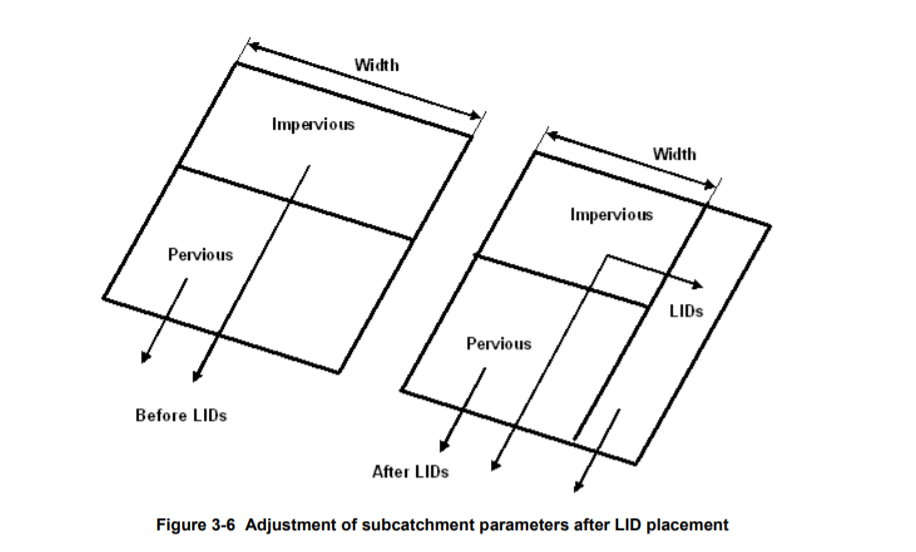

In [11]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230504.828, '72631': 416735.38935480005, '72671': 294170.5357533, '72731': 502440.3354173, '72781': 528471.639723, '72951': 416940.820404, '73081': 542560.381989, '73121': 715174.7378677, '73171': 388175.62847379997, '73181': 429710.4424882, '73201': 488730.12524599995, '73211': 430857.0915683, '73301': 629184.12255, '73321': 433764.51918780006, '73391': 163959.81900000002, '73421': 501432.9761892, '73461': 523055.304277, '73531': 461421.794608, '73551': 411970.750493, '73571': 247200.738197}


## Percent Impervious area and Percent Pervious area treated changes according to total LID area implemented
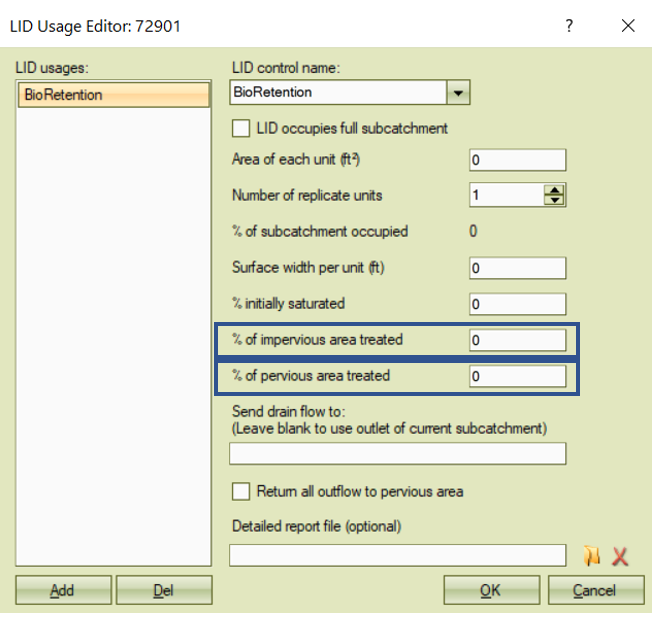

## Following blocks calculate updated percent Impervious area treated and percent impervious  changes for each subbasin based on LID scenario

### Calculations for RainGarden Percent Impervious Area Treated for each Subbasin

In [12]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (raingarden_assigned_areas[key] / raingarden_standard_surfaceareas[key])
print(totalunits)

{'72591': 9.01456498871942, '72631': 2.2733838626052933, '72671': 6.312341004529593, '72731': 2.7555372702821326, '72781': 3.3108373691749695, '72951': 7.628762710846605, '73081': 1.8183142842992348, '73121': 2.927905388854428, '73171': 0.0, '73181': 0.3327806462955621, '73201': 0.9984794094213785, '73211': 2.1394089458945373, '73301': 0.06694804706572957, '73321': 0.06069085004574922, '73391': 1.4059856513417879, '73421': 0.0, '73461': 0.5081180585316525, '73531': 1.9705548747235468, '73551': 1.0875553912388112, '73571': 0.7738833643494533}


In [13]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 21780
print(totaldrainageareatreated)

{'72591': 196337.22545430897, '72631': 49514.30052754329, '72671': 137482.78707865454, '72731': 60015.60174674485, '72781': 72110.03790063084, '72951': 166154.45184223904, '73081': 39602.88511203734, '73121': 63769.779369249445, '73171': 0.0, '73181': 7247.962476317342, '73201': 21746.881537197623, '73211': 46596.326841583024, '73301': 1458.12846509159, '73321': 1321.846713996418, '73391': 30622.36748622414, '73421': 0.0, '73461': 11066.811314819392, '73531': 42918.68517147885, '73551': 23686.95642118131, '73571': 16855.179675531093}


In [14]:
raingarden_impervareatreated = subbasindict

for key in raingarden_impervareatreated:
    quarter = 0.25
    raingarden_impervareatreated[key] = totaldrainageareatreated[key] * quarter
print(raingarden_impervareatreated)

{'72591': 49084.30636357724, '72631': 12378.575131885822, '72671': 34370.696769663635, '72731': 15003.900436686212, '72781': 18027.50947515771, '72951': 41538.61296055976, '73081': 9900.721278009334, '73121': 15942.444842312361, '73171': 0.0, '73181': 1811.9906190793356, '73201': 5436.720384299406, '73211': 11649.081710395756, '73301': 364.5321162728975, '73321': 330.4616784991045, '73391': 7655.591871556035, '73421': 0.0, '73461': 2766.702828704848, '73531': 10729.671292869712, '73551': 5921.739105295327, '73571': 4213.794918882773}


In [15]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230504.828, '72631': 416735.38935480005, '72671': 294170.5357533, '72731': 502440.3354173, '72781': 528471.639723, '72951': 416940.820404, '73081': 542560.381989, '73121': 715174.7378677, '73171': 388175.62847379997, '73181': 429710.4424882, '73201': 488730.12524599995, '73211': 430857.0915683, '73301': 629184.12255, '73321': 433764.51918780006, '73391': 163959.81900000002, '73421': 501432.9761892, '73461': 523055.304277, '73531': 461421.794608, '73551': 411970.750493, '73571': 247200.738197}


In [16]:
raingarden_percimpervareatreated = subbasindict

for key in raingarden_percimpervareatreated:
    raingarden_percimpervareatreated[key] = (raingarden_impervareatreated[key]/updated_sb_impervious_areas[key])*100
print(raingarden_percimpervareatreated)

{'72591': 21.29426389436721, '72631': 2.9703681156166355, '72671': 11.683935878094843, '72731': 2.9862054017269086, '72781': 3.411253910353048, '72951': 9.962711955214749, '73081': 1.8248146393796338, '73121': 2.2291677821066367, '73171': 0.0, '73181': 0.42167712019916614, '73201': 1.1124176930085616, '73211': 2.703699657813136, '73301': 0.05793727196984836, '73321': 0.07618458031511559, '73391': 4.669187803602073, '73421': 0.0, '73461': 0.5289503435070138, '73531': 2.325349911567373, '73551': 1.437417364754381, '73571': 1.7046045046696836}


In [17]:
for key in raingarden_percimpervareatreated:
    if raingarden_percimpervareatreated[key] > 100:
        raingarden_percimpervareatreated[key] = 100
print(raingarden_percimpervareatreated)

{'72591': 21.29426389436721, '72631': 2.9703681156166355, '72671': 11.683935878094843, '72731': 2.9862054017269086, '72781': 3.411253910353048, '72951': 9.962711955214749, '73081': 1.8248146393796338, '73121': 2.2291677821066367, '73171': 0.0, '73181': 0.42167712019916614, '73201': 1.1124176930085616, '73211': 2.703699657813136, '73301': 0.05793727196984836, '73321': 0.07618458031511559, '73391': 4.669187803602073, '73421': 0.0, '73461': 0.5289503435070138, '73531': 2.325349911567373, '73551': 1.437417364754381, '73571': 1.7046045046696836}


### Calculations for RainGarden Percent Pervious Area Treated for each Subbasin

In [18]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230504.828, '72631': 416735.38935480005, '72671': 294170.5357533, '72731': 502440.3354173, '72781': 528471.639723, '72951': 416940.820404, '73081': 542560.381989, '73121': 715174.7378677, '73171': 388175.62847379997, '73181': 429710.4424882, '73201': 488730.12524599995, '73211': 430857.0915683, '73301': 629184.12255, '73321': 433764.51918780006, '73391': 163959.81900000002, '73421': 501432.9761892, '73461': 523055.304277, '73531': 461421.794608, '73551': 411970.750493, '73571': 247200.738197}


In [19]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (raingarden_assigned_areas[key] / raingarden_standard_surfaceareas[key])
print(totalunits)

{'72591': 9.01456498871942, '72631': 2.2733838626052933, '72671': 6.312341004529593, '72731': 2.7555372702821326, '72781': 3.3108373691749695, '72951': 7.628762710846605, '73081': 1.8183142842992348, '73121': 2.927905388854428, '73171': 0.0, '73181': 0.3327806462955621, '73201': 0.9984794094213785, '73211': 2.1394089458945373, '73301': 0.06694804706572957, '73321': 0.06069085004574922, '73391': 1.4059856513417879, '73421': 0.0, '73461': 0.5081180585316525, '73531': 1.9705548747235468, '73551': 1.0875553912388112, '73571': 0.7738833643494533}


In [20]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 21780
print(totaldrainageareatreated)

{'72591': 196337.22545430897, '72631': 49514.30052754329, '72671': 137482.78707865454, '72731': 60015.60174674485, '72781': 72110.03790063084, '72951': 166154.45184223904, '73081': 39602.88511203734, '73121': 63769.779369249445, '73171': 0.0, '73181': 7247.962476317342, '73201': 21746.881537197623, '73211': 46596.326841583024, '73301': 1458.12846509159, '73321': 1321.846713996418, '73391': 30622.36748622414, '73421': 0.0, '73461': 11066.811314819392, '73531': 42918.68517147885, '73551': 23686.95642118131, '73571': 16855.179675531093}


In [21]:
raingarden_pervareatreated = subbasindict

for key in raingarden_pervareatreated:
    threequarter = 0.75
    raingarden_pervareatreated[key] = totaldrainageareatreated[key] * threequarter
print(raingarden_pervareatreated)

{'72591': 147252.9190907317, '72631': 37135.725395657464, '72671': 103112.09030899091, '72731': 45011.701310058634, '72781': 54082.52842547312, '72951': 124615.83888167929, '73081': 29702.163834028004, '73121': 47827.334526937084, '73171': 0.0, '73181': 5435.971857238007, '73201': 16310.161152898218, '73211': 34947.24513118727, '73301': 1093.5963488186926, '73321': 991.3850354973135, '73391': 22966.775614668106, '73421': 0.0, '73461': 8300.108486114543, '73531': 32189.013878609137, '73551': 17765.21731588598, '73571': 12641.38475664832}


In [22]:
raingarden_percpervareatreated = subbasindict

for key in raingarden_percimpervareatreated:
    raingarden_percpervareatreated[key] = (raingarden_pervareatreated[key]/subbasin_perv_areas[key])*100
print(raingarden_percpervareatreated)

{'72591': 21.045814357600094, '72631': 6.958678137920808, '72671': 14.373164212357365, '72731': 10.042992140957907, '72781': 4.831017663219725, '72951': 9.121506028709764, '73081': 3.0126893290811743, '73121': 6.255880864987732, '73171': 0.0, '73181': 2.789375297632661, '73201': 3.811444738782698, '73211': 3.876033821809546, '73301': 0.14631785750246734, '73321': 0.5156288040065584, '73391': 3.838266586288973, '73421': 0.0, '73461': 4.734709800166286, '73531': 15.498576468286354, '73551': 9.338162982951413, '73571': 10.933641747366682}


In [23]:
for key in raingarden_percpervareatreated:
    if raingarden_percpervareatreated[key] > 100:
        raingarden_percpervareatreated[key] = 100
print(raingarden_percpervareatreated)

{'72591': 21.045814357600094, '72631': 6.958678137920808, '72671': 14.373164212357365, '72731': 10.042992140957907, '72781': 4.831017663219725, '72951': 9.121506028709764, '73081': 3.0126893290811743, '73121': 6.255880864987732, '73171': 0.0, '73181': 2.789375297632661, '73201': 3.811444738782698, '73211': 3.876033821809546, '73301': 0.14631785750246734, '73321': 0.5156288040065584, '73391': 3.838266586288973, '73421': 0.0, '73461': 4.734709800166286, '73531': 15.498576468286354, '73551': 9.338162982951413, '73571': 10.933641747366682}


# Bioretention LID Usage Editor Parameter Changes!

### Percent of Impervious Area Treated Calculations for each Subbasin

In [24]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230504.828, '72631': 416735.38935480005, '72671': 294170.5357533, '72731': 502440.3354173, '72781': 528471.639723, '72951': 416940.820404, '73081': 542560.381989, '73121': 715174.7378677, '73171': 388175.62847379997, '73181': 429710.4424882, '73201': 488730.12524599995, '73211': 430857.0915683, '73301': 629184.12255, '73321': 433764.51918780006, '73391': 163959.81900000002, '73421': 501432.9761892, '73461': 523055.304277, '73531': 461421.794608, '73551': 411970.750493, '73571': 247200.738197}


In [25]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (bioretention_assigned_areas[key] / bioretention_standard_surfaceareas[key])
print(totalunits)

{'72591': 0.03350298723287122, '72631': 0.02370061049559241, '72671': 0.029527155917832046, '72731': 0.08131656183591442, '72781': 0.00022069237354415853, '72951': 0.03612026026890401, '73081': 0.0, '73121': 0.12657413190250694, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.03050745636227347, '73421': 0.0, '73461': 0.0, '73531': 0.019519450471313118, '73551': 0.0, '73571': 0.07426153498507265}


In [26]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 163350
print(totaldrainageareatreated)

{'72591': 5472.712964489514, '72631': 3871.4947244550203, '72671': 4823.260919177865, '72731': 13283.06037589662, '72781': 36.0500992184383, '72951': 5900.24451492547, '73081': 0.0, '73121': 20675.884446274507, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 4983.392996777371, '73421': 0.0, '73461': 0.0, '73531': 3188.5022344889976, '73551': 0.0, '73571': 12130.621739811619}


In [27]:
bioretention_impervareatreated = subbasindict

for key in bioretention_impervareatreated:
    bioretention_impervareatreated[key] = totaldrainageareatreated[key] * 0.5
print(bioretention_impervareatreated)

{'72591': 2736.356482244757, '72631': 1935.7473622275102, '72671': 2411.6304595889324, '72731': 6641.53018794831, '72781': 18.02504960921915, '72951': 2950.122257462735, '73081': 0.0, '73121': 10337.942223137254, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 2491.6964983886855, '73421': 0.0, '73461': 0.0, '73531': 1594.2511172444988, '73551': 0.0, '73571': 6065.310869905809}


In [28]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230504.828, '72631': 416735.38935480005, '72671': 294170.5357533, '72731': 502440.3354173, '72781': 528471.639723, '72951': 416940.820404, '73081': 542560.381989, '73121': 715174.7378677, '73171': 388175.62847379997, '73181': 429710.4424882, '73201': 488730.12524599995, '73211': 430857.0915683, '73301': 629184.12255, '73321': 433764.51918780006, '73391': 163959.81900000002, '73421': 501432.9761892, '73461': 523055.304277, '73531': 461421.794608, '73551': 411970.750493, '73571': 247200.738197}


In [29]:
bioretention_percimpervareatreated = subbasindict

for key in bioretention_percimpervareatreated:
    bioretention_percimpervareatreated[key] = (bioretention_impervareatreated[key]/updated_sb_impervious_areas[key])*100
print(bioretention_percimpervareatreated)

{'72591': 1.1871146066601073, '72631': 0.46450275442757133, '72671': 0.8198069372968733, '72731': 1.321854500879634, '72781': 0.0034107884424350626, '72951': 0.7075637867753455, '73081': 0.0, '73121': 1.4455127783120418, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 1.5196994688001488, '73421': 0.0, '73461': 0.0, '73531': 0.3455084124491544, '73551': 0.0, '73571': 2.4535973938201683}


In [30]:
for key in bioretention_percimpervareatreated:
    if bioretention_percimpervareatreated[key] > 100:
        bioretention_percimpervareatreated[key] = 100
print(bioretention_percimpervareatreated)

{'72591': 1.1871146066601073, '72631': 0.46450275442757133, '72671': 0.8198069372968733, '72731': 1.321854500879634, '72781': 0.0034107884424350626, '72951': 0.7075637867753455, '73081': 0.0, '73121': 1.4455127783120418, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 1.5196994688001488, '73421': 0.0, '73461': 0.0, '73531': 0.3455084124491544, '73551': 0.0, '73571': 2.4535973938201683}


### Bioretention Percent Pervious Area Treated for each Subbasin

In [31]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230504.828, '72631': 416735.38935480005, '72671': 294170.5357533, '72731': 502440.3354173, '72781': 528471.639723, '72951': 416940.820404, '73081': 542560.381989, '73121': 715174.7378677, '73171': 388175.62847379997, '73181': 429710.4424882, '73201': 488730.12524599995, '73211': 430857.0915683, '73301': 629184.12255, '73321': 433764.51918780006, '73391': 163959.81900000002, '73421': 501432.9761892, '73461': 523055.304277, '73531': 461421.794608, '73551': 411970.750493, '73571': 247200.738197}


In [32]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (bioretention_assigned_areas[key] / bioretention_standard_surfaceareas[key])
print(totalunits)

{'72591': 0.03350298723287122, '72631': 0.02370061049559241, '72671': 0.029527155917832046, '72731': 0.08131656183591442, '72781': 0.00022069237354415853, '72951': 0.03612026026890401, '73081': 0.0, '73121': 0.12657413190250694, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.03050745636227347, '73421': 0.0, '73461': 0.0, '73531': 0.019519450471313118, '73551': 0.0, '73571': 0.07426153498507265}


In [33]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 163350
print(totaldrainageareatreated)

{'72591': 5472.712964489514, '72631': 3871.4947244550203, '72671': 4823.260919177865, '72731': 13283.06037589662, '72781': 36.0500992184383, '72951': 5900.24451492547, '73081': 0.0, '73121': 20675.884446274507, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 4983.392996777371, '73421': 0.0, '73461': 0.0, '73531': 3188.5022344889976, '73551': 0.0, '73571': 12130.621739811619}


In [34]:
bioretention_pervareatreated = subbasindict

for key in bioretention_pervareatreated:
    bioretention_pervareatreated[key] = totaldrainageareatreated[key] * 0.5
print(bioretention_pervareatreated)

{'72591': 2736.356482244757, '72631': 1935.7473622275102, '72671': 2411.6304595889324, '72731': 6641.53018794831, '72781': 18.02504960921915, '72951': 2950.122257462735, '73081': 0.0, '73121': 10337.942223137254, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 2491.6964983886855, '73421': 0.0, '73461': 0.0, '73531': 1594.2511172444988, '73551': 0.0, '73571': 6065.310869905809}


In [35]:
bioretention_percpervareatreated = subbasindict

for key in bioretention_percpervareatreated:
    bioretention_percpervareatreated[key] = (bioretention_pervareatreated[key]/subbasin_perv_areas[key])*100
print(bioretention_percpervareatreated)

{'72591': 0.39108800624899465, '72631': 0.36273003170272294, '72671': 0.33616582217781066, '72731': 1.48185546291702, '72781': 0.0016101194891904261, '72951': 0.21594011000822602, '73081': 0.0, '73121': 1.3522170026148603, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.4164187247438623, '73421': 0.0, '73461': 0.0, '73531': 0.7676104320388848, '73551': 0.0, '73571': 5.2459392237929}


In [36]:
for key in bioretention_percpervareatreated:
    if bioretention_percpervareatreated[key] > 100:
        bioretention_percpervareatreated[key] = 100
print(bioretention_percpervareatreated)

{'72591': 0.39108800624899465, '72631': 0.36273003170272294, '72671': 0.33616582217781066, '72731': 1.48185546291702, '72781': 0.0016101194891904261, '72951': 0.21594011000822602, '73081': 0.0, '73121': 1.3522170026148603, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.4164187247438623, '73421': 0.0, '73461': 0.0, '73531': 0.7676104320388848, '73551': 0.0, '73571': 5.2459392237929}


# Grass Swale LID Usage Editor Parameter Changes!

### Percent of Impervious Area Treated Calculations for each Subbasin

In [37]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230504.828, '72631': 416735.38935480005, '72671': 294170.5357533, '72731': 502440.3354173, '72781': 528471.639723, '72951': 416940.820404, '73081': 542560.381989, '73121': 715174.7378677, '73171': 388175.62847379997, '73181': 429710.4424882, '73201': 488730.12524599995, '73211': 430857.0915683, '73301': 629184.12255, '73321': 433764.51918780006, '73391': 163959.81900000002, '73421': 501432.9761892, '73461': 523055.304277, '73531': 461421.794608, '73551': 411970.750493, '73571': 247200.738197}


In [38]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (grassswale_assigned_areas[key] / grassswale_standard_surfaceareas[key])
print(totalunits)

{'72591': 0.028854247379010486, '72631': 0.030618013562802353, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 0.15670600345200708, '73081': 0.08133771055085201, '73121': 0.0218022428171903, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.12322676873178426, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 0.038454328332112785}


In [39]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 163350
print(totaldrainageareatreated)

{'72591': 4713.341309361363, '72631': 5001.452515483765, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 25597.925663885355, '73081': 13286.515018481676, '73121': 3561.3963641880355, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 20129.09267233696, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 6281.514533050623}


In [40]:
grassswale_impervareatreated = subbasindict

for key in grassswale_impervareatreated:
    grassswale_impervareatreated[key] = totaldrainageareatreated[key] * 0.5
print(grassswale_impervareatreated)

{'72591': 2356.6706546806813, '72631': 2500.7262577418824, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 12798.962831942677, '73081': 6643.257509240838, '73121': 1780.6981820940177, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 10064.54633616848, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 3140.7572665253115}


In [41]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230504.828, '72631': 416735.38935480005, '72671': 294170.5357533, '72731': 502440.3354173, '72781': 528471.639723, '72951': 416940.820404, '73081': 542560.381989, '73121': 715174.7378677, '73171': 388175.62847379997, '73181': 429710.4424882, '73201': 488730.12524599995, '73211': 430857.0915683, '73301': 629184.12255, '73321': 433764.51918780006, '73391': 163959.81900000002, '73421': 501432.9761892, '73461': 523055.304277, '73531': 461421.794608, '73551': 411970.750493, '73571': 247200.738197}


In [42]:
grassswale_percimpervareatreated = subbasindict

for key in grassswale_percimpervareatreated:
    grassswale_percimpervareatreated[key] = (grassswale_impervareatreated[key]/updated_sb_impervious_areas[key])*100
print(grassswale_percimpervareatreated)

{'72591': 1.0223953550685199, '72631': 0.6000753287628315, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 3.0697312917312733, '73081': 1.2244273134884966, '73121': 0.24898784699850912, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 6.138422448593017, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 1.2705290807110654}


In [43]:
for key in grassswale_percimpervareatreated:
    if grassswale_percimpervareatreated[key] > 100:
        grassswale_percimpervareatreated[key] = 100
print(grassswale_percimpervareatreated)

{'72591': 1.0223953550685199, '72631': 0.6000753287628315, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 3.0697312917312733, '73081': 1.2244273134884966, '73121': 0.24898784699850912, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 6.138422448593017, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 1.2705290807110654}


### Percent of pervious Area Treated Calculations for each Subbasin

In [44]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230504.828, '72631': 416735.38935480005, '72671': 294170.5357533, '72731': 502440.3354173, '72781': 528471.639723, '72951': 416940.820404, '73081': 542560.381989, '73121': 715174.7378677, '73171': 388175.62847379997, '73181': 429710.4424882, '73201': 488730.12524599995, '73211': 430857.0915683, '73301': 629184.12255, '73321': 433764.51918780006, '73391': 163959.81900000002, '73421': 501432.9761892, '73461': 523055.304277, '73531': 461421.794608, '73551': 411970.750493, '73571': 247200.738197}


In [45]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (grassswale_assigned_areas[key] / grassswale_standard_surfaceareas[key])
print(totalunits)

{'72591': 0.028854247379010486, '72631': 0.030618013562802353, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 0.15670600345200708, '73081': 0.08133771055085201, '73121': 0.0218022428171903, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.12322676873178426, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 0.038454328332112785}


In [46]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 163350
print(totaldrainageareatreated)

{'72591': 4713.341309361363, '72631': 5001.452515483765, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 25597.925663885355, '73081': 13286.515018481676, '73121': 3561.3963641880355, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 20129.09267233696, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 6281.514533050623}


In [47]:
grassswale_pervareatreated = subbasindict

for key in grassswale_pervareatreated:
    grassswale_pervareatreated[key] = totaldrainageareatreated[key] * 0.5
print(grassswale_pervareatreated)

{'72591': 2356.6706546806813, '72631': 2500.7262577418824, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 12798.962831942677, '73081': 6643.257509240838, '73121': 1780.6981820940177, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 10064.54633616848, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 3140.7572665253115}


In [48]:
grassswale_percpervareatreated = subbasindict

for key in grassswale_percpervareatreated:
    grassswale_percpervareatreated[key] = (grassswale_pervareatreated[key]/subbasin_perv_areas[key])*100
print(grassswale_percpervareatreated)

{'72591': 0.3368222063554002, '72631': 0.46859860560870736, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 0.936845730691149, '73081': 0.6738253522626968, '73121': 0.2329177612314205, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 1.682012858766323, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 2.7164678101872073}


In [49]:
for key in grassswale_percimpervareatreated:
    if grassswale_percimpervareatreated[key] > 100:
        grassswale_percimpervareatreated[key] = 100
print(grassswale_percpervareatreated)

{'72591': 0.3368222063554002, '72631': 0.46859860560870736, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 0.936845730691149, '73081': 0.6738253522626968, '73121': 0.2329177612314205, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 1.682012858766323, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 2.7164678101872073}


## Capping total %impervious and %pervious area treated at 100% for each subcatchment-LID combo. 

In [50]:
subbasinlist = ['72591', '72631', '72671', '72731', '72781', '72951', '73081','73121','73171','73181', '73201', '73211', '73301', '73321', '73391', '73421', '73461', '73531', '73551','73571']
percimptreated_sbs = dict.fromkeys(subbasinlist)

for key in percimptreated_sbs:
    percimptreated_sbs[key] = raingarden_percimpervareatreated[key] + bioretention_percimpervareatreated[key] + permeablepavement_percimpervtreated[key] + grassswale_percimpervareatreated[key]
print(percimptreated_sbs)  

{'72591': 23.503773856095833, '72631': 4.250433910779455, '72671': 12.503742815391716, '72731': 4.802419039734146, '72781': 4.008524890450231, '72951': 14.602652957072051, '73081': 3.4956213016737907, '73121': 4.372071235803058, '73171': 0.6296592492449512, '73181': 0.8600380055182905, '73201': 2.654113121790945, '73211': 2.7661559815608774, '73301': 0.7422457034271037, '73321': 0.45932657890731937, '73391': 12.49143377385236, '73421': 0.3662171295465652, '73461': 1.7636840221812269, '73531': 4.437190982170229, '73551': 1.437417364754381, '73571': 7.535620263993192}


In [51]:
while percimptreated_sbs['72671'] > 100:
    raingarden_percimpervareatreated['72671'] =  raingarden_percimpervareatreated['72671']-0.25
    for key in percimptreated_sbs:
        percimptreated_sbs[key] = raingarden_percimpervareatreated[key] + bioretention_percimpervareatreated[key] + permeablepavement_percimpervtreated[key] + grassswale_percimpervareatreated[key]
        
print(percimptreated_sbs)


{'72591': 23.503773856095833, '72631': 4.250433910779455, '72671': 12.503742815391716, '72731': 4.802419039734146, '72781': 4.008524890450231, '72951': 14.602652957072051, '73081': 3.4956213016737907, '73121': 4.372071235803058, '73171': 0.6296592492449512, '73181': 0.8600380055182905, '73201': 2.654113121790945, '73211': 2.7661559815608774, '73301': 0.7422457034271037, '73321': 0.45932657890731937, '73391': 12.49143377385236, '73421': 0.3662171295465652, '73461': 1.7636840221812269, '73531': 4.437190982170229, '73551': 1.437417364754381, '73571': 7.535620263993192}


In [52]:
subbasinlist = ['72591', '72631', '72671', '72731', '72781', '72951', '73081','73121','73171','73181', '73201', '73211', '73301', '73321', '73391', '73421', '73461', '73531', '73551','73571']
percpervtreated_sbs = dict.fromkeys(subbasinlist)

for key in percpervtreated_sbs:
    percpervtreated_sbs[key] = raingarden_percpervareatreated[key] + bioretention_percpervareatreated[key] + grassswale_percpervareatreated[key]
print(percpervtreated_sbs)  

{'72591': 21.77372457020449, '72631': 7.790006775232238, '72671': 14.709330034535176, '72731': 11.524847603874926, '72781': 4.832627782708915, '72951': 10.274291869409138, '73081': 3.686514681343871, '73121': 7.841015628834014, '73171': 0.0, '73181': 2.789375297632661, '73201': 3.811444738782698, '73211': 3.876033821809546, '73301': 0.14631785750246734, '73321': 0.5156288040065584, '73391': 5.9366981697991585, '73421': 0.0, '73461': 4.734709800166286, '73531': 16.266186900325238, '73551': 9.338162982951413, '73571': 18.89604878134679}


In [53]:
while percpervtreated_sbs['73571'] > 100:
    raingarden_percpervareatreated['73571'] =  raingarden_percpervareatreated['73571']-0.25
    for key in percpervtreated_sbs:
        percpervtreated_sbs[key] = raingarden_percpervareatreated[key] + bioretention_percpervareatreated[key] + grassswale_percpervareatreated[key] 
    


In [54]:
while percpervtreated_sbs['72591'] > 100:
    raingarden_percpervareatreated['72591'] =  raingarden_percpervareatreated['72591']-0.25
    for key in percpervtreated_sbs:
        percpervtreated_sbs[key] = raingarden_percpervareatreated[key] + bioretention_percpervareatreated[key] + grassswale_percpervareatreated[key] 
print(percpervtreated_sbs)


{'72591': 21.77372457020449, '72631': 7.790006775232238, '72671': 14.709330034535176, '72731': 11.524847603874926, '72781': 4.832627782708915, '72951': 10.274291869409138, '73081': 3.686514681343871, '73121': 7.841015628834014, '73171': 0.0, '73181': 2.789375297632661, '73201': 3.811444738782698, '73211': 3.876033821809546, '73301': 0.14631785750246734, '73321': 0.5156288040065584, '73391': 5.9366981697991585, '73421': 0.0, '73461': 4.734709800166286, '73531': 16.266186900325238, '73551': 9.338162982951413, '73571': 18.89604878134679}


In [55]:
while percimptreated_sbs['72591'] > 100:
    raingarden_percimpervareatreated['72591'] =  raingarden_percimpervareatreated['72591']-0.25
    for key in percimptreated_sbs:
        percimptreated_sbs[key] = raingarden_percimpervareatreated[key] + bioretention_percimpervareatreated[key] + permeablepavement_percimpervtreated[key] + grassswale_percimpervareatreated[key]
        
print(percimptreated_sbs)


{'72591': 23.503773856095833, '72631': 4.250433910779455, '72671': 12.503742815391716, '72731': 4.802419039734146, '72781': 4.008524890450231, '72951': 14.602652957072051, '73081': 3.4956213016737907, '73121': 4.372071235803058, '73171': 0.6296592492449512, '73181': 0.8600380055182905, '73201': 2.654113121790945, '73211': 2.7661559815608774, '73301': 0.7422457034271037, '73321': 0.45932657890731937, '73391': 12.49143377385236, '73421': 0.3662171295465652, '73461': 1.7636840221812269, '73531': 4.437190982170229, '73551': 1.437417364754381, '73571': 7.535620263993192}


In [56]:
while percimptreated_sbs['72951'] > 100:
    raingarden_percimpervareatreated['72951'] =  raingarden_percimpervareatreated['72951']-0.25
    for key in percimptreated_sbs:
        percimptreated_sbs[key] = raingarden_percimpervareatreated[key] + bioretention_percimpervareatreated[key] + permeablepavement_percimpervtreated[key] + grassswale_percimpervareatreated[key]
        
print(percimptreated_sbs)


{'72591': 23.503773856095833, '72631': 4.250433910779455, '72671': 12.503742815391716, '72731': 4.802419039734146, '72781': 4.008524890450231, '72951': 14.602652957072051, '73081': 3.4956213016737907, '73121': 4.372071235803058, '73171': 0.6296592492449512, '73181': 0.8600380055182905, '73201': 2.654113121790945, '73211': 2.7661559815608774, '73301': 0.7422457034271037, '73321': 0.45932657890731937, '73391': 12.49143377385236, '73421': 0.3662171295465652, '73461': 1.7636840221812269, '73531': 4.437190982170229, '73551': 1.437417364754381, '73571': 7.535620263993192}


In [57]:
while percimptreated_sbs['73391'] > 100:
    raingarden_percimpervareatreated['73391'] =  raingarden_percimpervareatreated['73391']-0.25
    for key in percimptreated_sbs:
        percimptreated_sbs[key] = raingarden_percimpervareatreated[key] + bioretention_percimpervareatreated[key] + permeablepavement_percimpervtreated[key] + grassswale_percimpervareatreated[key]
        
print(percimptreated_sbs)

{'72591': 23.503773856095833, '72631': 4.250433910779455, '72671': 12.503742815391716, '72731': 4.802419039734146, '72781': 4.008524890450231, '72951': 14.602652957072051, '73081': 3.4956213016737907, '73121': 4.372071235803058, '73171': 0.6296592492449512, '73181': 0.8600380055182905, '73201': 2.654113121790945, '73211': 2.7661559815608774, '73301': 0.7422457034271037, '73321': 0.45932657890731937, '73391': 12.49143377385236, '73421': 0.3662171295465652, '73461': 1.7636840221812269, '73531': 4.437190982170229, '73551': 1.437417364754381, '73571': 7.535620263993192}


In [58]:
while percpervtreated_sbs['72951'] > 100:
    raingarden_percpervareatreated['72951'] =  raingarden_percpervareatreated['72951']-0.25
    for key in percpervtreated_sbs:
        percpervtreated_sbs[key] = raingarden_percpervareatreated[key] + bioretention_percpervareatreated[key] + grassswale_percpervareatreated[key] 
print(percpervtreated_sbs)


{'72591': 21.77372457020449, '72631': 7.790006775232238, '72671': 14.709330034535176, '72731': 11.524847603874926, '72781': 4.832627782708915, '72951': 10.274291869409138, '73081': 3.686514681343871, '73121': 7.841015628834014, '73171': 0.0, '73181': 2.789375297632661, '73201': 3.811444738782698, '73211': 3.876033821809546, '73301': 0.14631785750246734, '73321': 0.5156288040065584, '73391': 5.9366981697991585, '73421': 0.0, '73461': 4.734709800166286, '73531': 16.266186900325238, '73551': 9.338162982951413, '73571': 18.89604878134679}


In [59]:
while percpervtreated_sbs['72731'] > 100:
    raingarden_percpervareatreated['72731'] =  raingarden_percpervareatreated['72731']-0.25
    for key in percpervtreated_sbs:
        percpervtreated_sbs[key] = raingarden_percpervareatreated[key] + bioretention_percpervareatreated[key] + grassswale_percpervareatreated[key] 
print(percpervtreated_sbs)

{'72591': 21.77372457020449, '72631': 7.790006775232238, '72671': 14.709330034535176, '72731': 11.524847603874926, '72781': 4.832627782708915, '72951': 10.274291869409138, '73081': 3.686514681343871, '73121': 7.841015628834014, '73171': 0.0, '73181': 2.789375297632661, '73201': 3.811444738782698, '73211': 3.876033821809546, '73301': 0.14631785750246734, '73321': 0.5156288040065584, '73391': 5.9366981697991585, '73421': 0.0, '73461': 4.734709800166286, '73531': 16.266186900325238, '73551': 9.338162982951413, '73571': 18.89604878134679}


In [60]:
while percpervtreated_sbs['73531'] > 100:
    raingarden_percpervareatreated['73531'] =  raingarden_percpervareatreated['73531']-0.25
    for key in percpervtreated_sbs:
        percpervtreated_sbs[key] = raingarden_percpervareatreated[key] + bioretention_percpervareatreated[key] + grassswale_percpervareatreated[key] 
print(percpervtreated_sbs)

{'72591': 21.77372457020449, '72631': 7.790006775232238, '72671': 14.709330034535176, '72731': 11.524847603874926, '72781': 4.832627782708915, '72951': 10.274291869409138, '73081': 3.686514681343871, '73121': 7.841015628834014, '73171': 0.0, '73181': 2.789375297632661, '73201': 3.811444738782698, '73211': 3.876033821809546, '73301': 0.14631785750246734, '73321': 0.5156288040065584, '73391': 5.9366981697991585, '73421': 0.0, '73461': 4.734709800166286, '73531': 16.266186900325238, '73551': 9.338162982951413, '73571': 18.89604878134679}


In [61]:
while percpervtreated_sbs['72671'] > 100:
    raingarden_percpervareatreated['72671'] =  raingarden_percpervareatreated['72671']-0.25
    for key in percpervtreated_sbs:
        percpervtreated_sbs[key] = raingarden_percpervareatreated[key] + bioretention_percpervareatreated[key] + grassswale_percpervareatreated[key] 
print(percpervtreated_sbs)

{'72591': 21.77372457020449, '72631': 7.790006775232238, '72671': 14.709330034535176, '72731': 11.524847603874926, '72781': 4.832627782708915, '72951': 10.274291869409138, '73081': 3.686514681343871, '73121': 7.841015628834014, '73171': 0.0, '73181': 2.789375297632661, '73201': 3.811444738782698, '73211': 3.876033821809546, '73301': 0.14631785750246734, '73321': 0.5156288040065584, '73391': 5.9366981697991585, '73421': 0.0, '73461': 4.734709800166286, '73531': 16.266186900325238, '73551': 9.338162982951413, '73571': 18.89604878134679}


In [62]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230504.828, '72631': 416735.38935480005, '72671': 294170.5357533, '72731': 502440.3354173, '72781': 528471.639723, '72951': 416940.820404, '73081': 542560.381989, '73121': 715174.7378677, '73171': 388175.62847379997, '73181': 429710.4424882, '73201': 488730.12524599995, '73211': 430857.0915683, '73301': 629184.12255, '73321': 433764.51918780006, '73391': 163959.81900000002, '73421': 501432.9761892, '73461': 523055.304277, '73531': 461421.794608, '73551': 411970.750493, '73571': 247200.738197}


In [63]:
print(subbasin_areas)

{'72591': 930398.04, '72631': 952047.36, '72671': 1011681.0, '72731': 954530.28, '72781': 1649965.68, '72951': 1785524.4, '73081': 1531569.6, '73121': 1481911.2, '73171': 677488.68, '73181': 626044.32, '73201': 922731.48, '73211': 1332718.2, '73301': 1379980.8, '73321': 629311.32, '73391': 762430.68, '73421': 672827.76, '73461': 708067.8, '73531': 677662.92, '73551': 603218.88, '73571': 368648.28}


In [64]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_percent_impervious_areas = subbasindict
for key in updated_sb_percent_impervious_areas:
    updated_sb_percent_impervious_areas[key] = (updated_sb_impervious_areas[key] / subbasin_areas[key])*100
print(updated_sb_percent_impervious_areas)

{'72591': 24.774861735521284, '72631': 43.7725481802502, '72671': 29.07740046055031, '72731': 52.637443352483274, '72781': 32.029250434045395, '72951': 23.351169012532118, '73081': 35.42512086874798, '73121': 48.26029642448887, '73171': 57.29625304939412, '73181': 68.63898110092269, '73201': 52.965584879145986, '73211': 32.32919694263198, '73301': 45.59368670564112, '73321': 68.92685788455229, '73391': 21.504882122529487, '73421': 74.52620209802284, '73461': 73.87079376819564, '73531': 68.09016414945648, '73551': 68.29540058378146, '73571': 67.05598577511334}


# The following block updates the SWMM input file by adjusting the subcatchment percent impervious and widths using SWMMIO (parameters not adjustable using pyswmm alone)
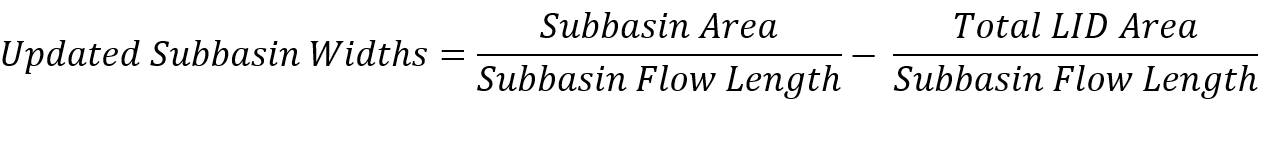

In [65]:
#initialize a baseline model object in swmmio
baseline = sio.Model(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\MeadowCreekSWMM')

#isolate subcatchments dataframe
subcatchments = baseline.inp.subcatchments

#Set subcatchment parameters

#Percent Impervious Adjustments

subcatchments.loc['73081','PercImperv'] = updated_sb_impervious_areas['73081']
subcatchments.loc['72671','PercImperv'] = updated_sb_impervious_areas['72671']
subcatchments.loc['72591','PercImperv'] = updated_sb_impervious_areas['72591']
subcatchments.loc['72631','PercImperv'] = updated_sb_impervious_areas['72631']
subcatchments.loc['72781','PercImperv'] = updated_sb_impervious_areas['72781']
subcatchments.loc['72731','PercImperv'] = updated_sb_impervious_areas['72731']
subcatchments.loc['72951','PercImperv'] = updated_sb_impervious_areas['72951']
subcatchments.loc['73211','PercImperv'] = updated_sb_impervious_areas['73211']
subcatchments.loc['73181','PercImperv'] = updated_sb_impervious_areas['73181']
subcatchments.loc['73171','PercImperv'] = updated_sb_impervious_areas['73171']
subcatchments.loc['73121','PercImperv'] = updated_sb_impervious_areas['73121']
subcatchments.loc['73201','PercImperv'] = updated_sb_impervious_areas['73201']
subcatchments.loc['73301','PercImperv'] = updated_sb_impervious_areas['73301']
subcatchments.loc['73321','PercImperv'] = updated_sb_impervious_areas['73321']
subcatchments.loc['73391','PercImperv'] = updated_sb_impervious_areas['73391']
subcatchments.loc['73461','PercImperv'] = updated_sb_impervious_areas['73461']
subcatchments.loc['73551','PercImperv'] = updated_sb_impervious_areas['73551']
subcatchments.loc['73421','PercImperv'] = updated_sb_impervious_areas['73421']
subcatchments.loc['73531','PercImperv'] = updated_sb_impervious_areas['73531']
subcatchments.loc['73571','PercImperv'] = updated_sb_impervious_areas['73571']

#Width Adjustment((SUBBASIN AREA/Flow Length) - LID Width)

subcatchments.loc['73081','Width'] = ((subcatchments.loc['73081','Area'] * 43560)/subbasin_flowlengths['73081']) - (lid_total_areas['73081']/subbasin_flowlengths['73081'])
subcatchments.loc['72671','Width'] = ((subcatchments.loc['72671','Area'] * 43560)/subbasin_flowlengths['72671']) - (lid_total_areas['73461']/subbasin_flowlengths['72671'])
subcatchments.loc['72591','Width'] = ((subcatchments.loc['72591','Area'] * 43560)/subbasin_flowlengths['72591']) - (lid_total_areas['72591']/subbasin_flowlengths['72591'])
subcatchments.loc['72631','Width'] = ((subcatchments.loc['72631','Area'] * 43560)/subbasin_flowlengths['72631']) - (lid_total_areas['72631']/subbasin_flowlengths['72631'])
subcatchments.loc['72781','Width'] = ((subcatchments.loc['72781','Area'] * 43560)/subbasin_flowlengths['72781']) - (lid_total_areas['72781']/subbasin_flowlengths['72781'])
subcatchments.loc['72731','Width'] = ((subcatchments.loc['72731','Area'] * 43560)/subbasin_flowlengths['72731']) - (lid_total_areas['72731']/subbasin_flowlengths['72731'])
subcatchments.loc['72951','Width'] = ((subcatchments.loc['72951','Area'] * 43560)/subbasin_flowlengths['72951']) - (lid_total_areas['72951']/subbasin_flowlengths['72951'])
subcatchments.loc['73211','Width'] = ((subcatchments.loc['73211','Area'] * 43560)/subbasin_flowlengths['73211']) - (lid_total_areas['73211']/subbasin_flowlengths['73211'])
subcatchments.loc['73181','Width'] = ((subcatchments.loc['73181','Area'] * 43560)/subbasin_flowlengths['73181']) - (lid_total_areas['73181']/subbasin_flowlengths['73181'])
subcatchments.loc['73171','Width'] = ((subcatchments.loc['73171','Area'] * 43560)/subbasin_flowlengths['73171']) - (lid_total_areas['73171']/subbasin_flowlengths['73171'])
subcatchments.loc['73121','Width'] = ((subcatchments.loc['73121','Area'] * 43560)/subbasin_flowlengths['73121']) - (lid_total_areas['73121']/subbasin_flowlengths['73121'])
subcatchments.loc['73201','Width'] = ((subcatchments.loc['73201','Area'] * 43560)/subbasin_flowlengths['73201']) - (lid_total_areas['73201']/subbasin_flowlengths['73201'])
subcatchments.loc['73301','Width'] = ((subcatchments.loc['73301','Area'] * 43560)/subbasin_flowlengths['73301']) - (lid_total_areas['73301']/subbasin_flowlengths['73301'])
subcatchments.loc['73321','Width'] = ((subcatchments.loc['73321','Area'] * 43560)/subbasin_flowlengths['73321']) - (lid_total_areas['73321']/subbasin_flowlengths['73321'])
subcatchments.loc['73391','Width'] = ((subcatchments.loc['73391','Area'] * 43560)/subbasin_flowlengths['73391']) - (lid_total_areas['73391']/subbasin_flowlengths['73391'])
subcatchments.loc['73461','Width'] = ((subcatchments.loc['73461','Area'] * 43560)/subbasin_flowlengths['73461']) - (lid_total_areas['73461']/subbasin_flowlengths['73461'])
subcatchments.loc['73551','Width'] = ((subcatchments.loc['73551','Area'] * 43560)/subbasin_flowlengths['73551']) - (lid_total_areas['73551']/subbasin_flowlengths['73551'])
subcatchments.loc['73421','Width'] = ((subcatchments.loc['73421','Area'] * 43560)/subbasin_flowlengths['73421']) - (lid_total_areas['73421']/subbasin_flowlengths['73421'])
subcatchments.loc['73531','Width'] = ((subcatchments.loc['73531','Area'] * 43560)/subbasin_flowlengths['73531']) - (lid_total_areas['73531']/subbasin_flowlengths['73531'])
subcatchments.loc['73571','Width'] = ((subcatchments.loc['73571','Area'] * 43560)/subbasin_flowlengths['73571']) - (lid_total_areas['73571']/subbasin_flowlengths['73571'])

#save subcatchment dataframe changes to whole inp dataframe
baseline.inp.subcatchments = subcatchments

#create the new inp file to use. 
newfilepath = os.path.join(r"C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS", baseline.inp.name + "_" + 'Adjusted_SB_Parameters' + '.inp')
    
#Write the subcatchment section of the new model with the adjusted data

baseline.inp.save(newfilepath)

# 

# PYSWMM simulation with LID adjustments

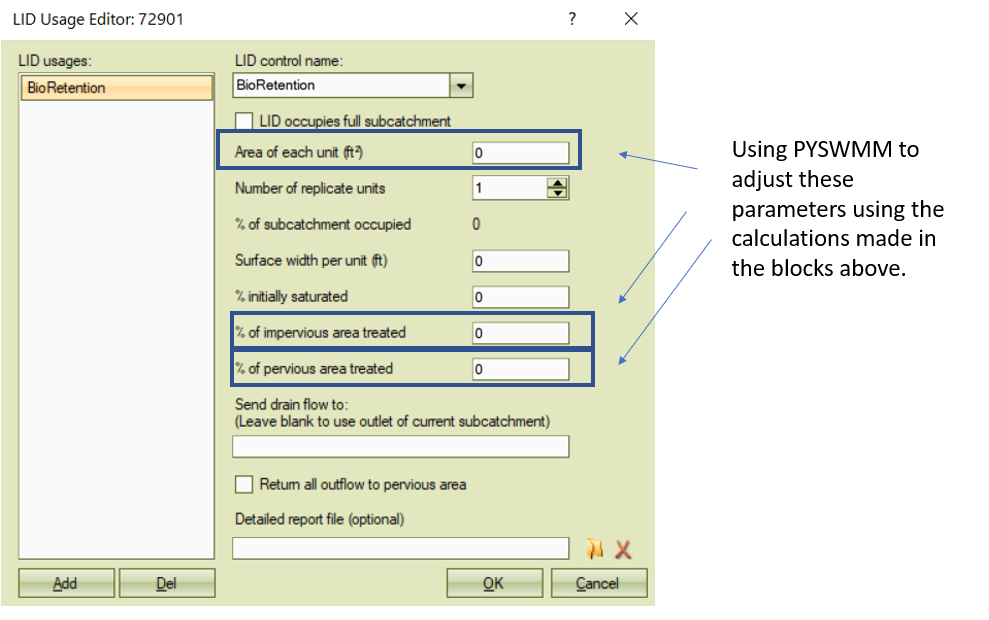

In [66]:
with Simulation(r"C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.inp", reportfile = r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt') as sim:
    
    
    control_time_step = 86400*3
    sim.step_advance(control_time_step)
    
    
    #Load in subcatchment lid list
    
    lid_sub_73081 = LidGroups(sim)['73081']
    lid_sub_72671 = LidGroups(sim)['72671']
    lid_sub_72591 = LidGroups(sim)['72591']
    lid_sub_72631 = LidGroups(sim)['72631']
    lid_sub_72781 = LidGroups(sim)['72781']
    lid_sub_72731 = LidGroups(sim)['72731']
    lid_sub_72951 = LidGroups(sim)['72951']
    lid_sub_73211 = LidGroups(sim)['73211']
    lid_sub_73181 = LidGroups(sim)['73181']
    lid_sub_73171 = LidGroups(sim)['73171']
    lid_sub_73121 = LidGroups(sim)['73121']
    lid_sub_73201 = LidGroups(sim)['73201']
    lid_sub_73301 = LidGroups(sim)['73301']
    lid_sub_73321 = LidGroups(sim)['73321']
    lid_sub_73391 = LidGroups(sim)['73391']
    lid_sub_73461 = LidGroups(sim)['73461']
    lid_sub_73551 = LidGroups(sim)['73551']
    lid_sub_73421 = LidGroups(sim)['73421']
    lid_sub_73531 = LidGroups(sim)['73531']
    lid_sub_73571 = LidGroups(sim)['73571']
    
    
#     #Set LID Areas!
    
    lid_sub_73081[0].unit_area = greenroof_assigned_areas['73081']
    lid_sub_73081[1].unit_area = permeablepavement_assigned_areas['73081']
    lid_sub_73081[2].unit_area = raingarden_assigned_areas['73081']
    lid_sub_73081[3].unit_area = bioretention_assigned_areas['73081']
    lid_sub_73081[4].unit_area = grassswale_assigned_areas['73081']
    
    lid_sub_72671[0].unit_area = greenroof_assigned_areas['72671']
    lid_sub_72671[1].unit_area = permeablepavement_assigned_areas['72671']
    lid_sub_72671[2].unit_area = raingarden_assigned_areas['72671']
    lid_sub_72671[3].unit_area = bioretention_assigned_areas['72671']
    lid_sub_72671[4].unit_area = grassswale_assigned_areas['72671']
    
    lid_sub_72591[0].unit_area = greenroof_assigned_areas['72591']
    lid_sub_72591[1].unit_area = permeablepavement_assigned_areas['72591']
    lid_sub_72591[2].unit_area = raingarden_assigned_areas['72591']
    lid_sub_72591[3].unit_area = bioretention_assigned_areas['72591']
    lid_sub_72591[4].unit_area = grassswale_assigned_areas['72591']
    
    lid_sub_72631[0].unit_area = greenroof_assigned_areas['72631']
    lid_sub_72631[1].unit_area = permeablepavement_assigned_areas['72631']
    lid_sub_72631[2].unit_area = raingarden_assigned_areas['72631']
    lid_sub_72631[3].unit_area = bioretention_assigned_areas['72631']
    lid_sub_72631[4].unit_area = grassswale_assigned_areas['72631']
    
    lid_sub_72781[0].unit_area = greenroof_assigned_areas['72781']
    lid_sub_72781[1].unit_area = permeablepavement_assigned_areas['72781']
    lid_sub_72781[2].unit_area = raingarden_assigned_areas['72781']
    lid_sub_72781[3].unit_area = bioretention_assigned_areas['72781']
    lid_sub_72781[4].unit_area = grassswale_assigned_areas['72781']
    
    lid_sub_72731[0].unit_area = greenroof_assigned_areas['72731']
    lid_sub_72731[1].unit_area = permeablepavement_assigned_areas['72731']
    lid_sub_72731[2].unit_area = raingarden_assigned_areas['72731']
    lid_sub_72731[3].unit_area = bioretention_assigned_areas['72731']
    lid_sub_72731[4].unit_area = grassswale_assigned_areas['72731']
    
    lid_sub_72951[0].unit_area = greenroof_assigned_areas['72951']
    lid_sub_72951[1].unit_area = permeablepavement_assigned_areas['72951']
    lid_sub_72951[2].unit_area = raingarden_assigned_areas['72951']
    lid_sub_72951[3].unit_area = bioretention_assigned_areas['72951']
    lid_sub_72951[4].unit_area = grassswale_assigned_areas['72951']
    
    lid_sub_73211[0].unit_area = greenroof_assigned_areas['73211']
    lid_sub_73211[1].unit_area = permeablepavement_assigned_areas['73211']
    lid_sub_73211[2].unit_area = raingarden_assigned_areas['73211']
    lid_sub_73211[3].unit_area = bioretention_assigned_areas['73211']
    lid_sub_73211[4].unit_area = grassswale_assigned_areas['73211']
    
    lid_sub_73181[0].unit_area = greenroof_assigned_areas['73181']
    lid_sub_73181[1].unit_area = permeablepavement_assigned_areas['73181']
    lid_sub_73181[2].unit_area = raingarden_assigned_areas['73181']
    lid_sub_73181[3].unit_area = bioretention_assigned_areas['73181']
    lid_sub_73181[4].unit_area = grassswale_assigned_areas['73181']
    
    lid_sub_73171[0].unit_area = greenroof_assigned_areas['73171']
    lid_sub_73171[1].unit_area = permeablepavement_assigned_areas['73171']
    lid_sub_73171[2].unit_area = raingarden_assigned_areas['73171']
    lid_sub_73171[3].unit_area = bioretention_assigned_areas['73171']
    lid_sub_73171[4].unit_area = grassswale_assigned_areas['73171']
    
    lid_sub_73121[0].unit_area = greenroof_assigned_areas['73121']
    lid_sub_73121[1].unit_area = permeablepavement_assigned_areas['73121']
    lid_sub_73121[2].unit_area = raingarden_assigned_areas['73121']
    lid_sub_73121[3].unit_area = bioretention_assigned_areas['73121']
    lid_sub_73121[4].unit_area = grassswale_assigned_areas['73121']
    
    lid_sub_73201[0].unit_area = greenroof_assigned_areas['73201']
    lid_sub_73201[1].unit_area = permeablepavement_assigned_areas['73201']
    lid_sub_73201[2].unit_area = raingarden_assigned_areas['73201']
    lid_sub_73201[3].unit_area = bioretention_assigned_areas['73201']
    lid_sub_73201[4].unit_area = grassswale_assigned_areas['73201']
    
    lid_sub_73301[0].unit_area = greenroof_assigned_areas['73301']
    lid_sub_73301[1].unit_area = permeablepavement_assigned_areas['73301']
    lid_sub_73301[2].unit_area = raingarden_assigned_areas['73301']
    lid_sub_73301[3].unit_area = bioretention_assigned_areas['73301']
    lid_sub_73301[4].unit_area = grassswale_assigned_areas['73301']
    
    lid_sub_73321[0].unit_area = greenroof_assigned_areas['73321']
    lid_sub_73321[1].unit_area = permeablepavement_assigned_areas['73321']
    lid_sub_73321[2].unit_area = raingarden_assigned_areas['73321']
    lid_sub_73321[3].unit_area = bioretention_assigned_areas['73321']
    lid_sub_73321[4].unit_area = grassswale_assigned_areas['73321']
    
    lid_sub_73391[0].unit_area = greenroof_assigned_areas['73391']
    lid_sub_73391[1].unit_area = permeablepavement_assigned_areas['73391']
    lid_sub_73391[2].unit_area = raingarden_assigned_areas['73391']
    lid_sub_73391[3].unit_area = bioretention_assigned_areas['73391']
    lid_sub_73391[4].unit_area = grassswale_assigned_areas['73391']
    
    lid_sub_73461[0].unit_area = greenroof_assigned_areas['73461']
    lid_sub_73461[1].unit_area = permeablepavement_assigned_areas['73461']
    lid_sub_73461[2].unit_area = raingarden_assigned_areas['73461']
    lid_sub_73461[3].unit_area = bioretention_assigned_areas['73461']
    lid_sub_73461[4].unit_area = grassswale_assigned_areas['73461']
    
    lid_sub_73551[0].unit_area = greenroof_assigned_areas['73551']
    lid_sub_73551[1].unit_area = permeablepavement_assigned_areas['73551']
    lid_sub_73551[2].unit_area = raingarden_assigned_areas['73551']
    lid_sub_73551[3].unit_area = bioretention_assigned_areas['73551']
    lid_sub_73551[4].unit_area = grassswale_assigned_areas['73551']
    
    lid_sub_73421[0].unit_area = greenroof_assigned_areas['73421']
    lid_sub_73421[1].unit_area = permeablepavement_assigned_areas['73421']
    lid_sub_73421[2].unit_area = raingarden_assigned_areas['73421']
    lid_sub_73421[3].unit_area = bioretention_assigned_areas['73421']
    lid_sub_73421[4].unit_area = grassswale_assigned_areas['73421']
    
    lid_sub_73531[0].unit_area = greenroof_assigned_areas['73531']
    lid_sub_73531[1].unit_area = permeablepavement_assigned_areas['73531']
    lid_sub_73531[2].unit_area = raingarden_assigned_areas['73531']
    lid_sub_73531[3].unit_area = bioretention_assigned_areas['73531']
    lid_sub_73531[4].unit_area = grassswale_assigned_areas['73531']
    
    lid_sub_73571[0].unit_area = greenroof_assigned_areas['73571']
    lid_sub_73571[1].unit_area = permeablepavement_assigned_areas['73571']
    lid_sub_73571[2].unit_area = raingarden_assigned_areas['73571']
    lid_sub_73571[3].unit_area = bioretention_assigned_areas['73571']
    lid_sub_73571[4].unit_area = grassswale_assigned_areas['73571']
    
    
    
#Set Percent Impervious Areas Treated
    
    lid_sub_73081[1].from_impervious = permeablepavement_percimpervtreated['73081']
    lid_sub_73081[2].from_impervious = raingarden_percimpervareatreated['73081']
    lid_sub_73081[3].from_impervious = bioretention_percimpervareatreated['73081']
    lid_sub_73081[4].from_impervious = grassswale_percimpervareatreated['73081']
    
    lid_sub_72671[1].from_impervious = permeablepavement_percimpervtreated['72671']
    lid_sub_72671[2].from_impervious = raingarden_percimpervareatreated['72671']
    lid_sub_72671[3].from_impervious = bioretention_percimpervareatreated['72671']
    lid_sub_72671[4].from_impervious = grassswale_percimpervareatreated['72671']
    
    lid_sub_72591[1].from_impervious = permeablepavement_percimpervtreated['72591']
    lid_sub_72591[2].from_impervious = raingarden_percimpervareatreated['72591']
    lid_sub_72591[3].from_impervious = bioretention_percimpervareatreated['72591']
    lid_sub_72591[4].from_impervious = grassswale_percimpervareatreated['72591']
    
    lid_sub_72631[1].from_impervious = permeablepavement_percimpervtreated['72631']
    lid_sub_72631[2].from_impervious = raingarden_percimpervareatreated['72631']
    lid_sub_72631[3].from_impervious = bioretention_percimpervareatreated['72631']
    lid_sub_72631[4].from_impervious = grassswale_percimpervareatreated['72631']
    
    lid_sub_72781[1].from_impervious = permeablepavement_percimpervtreated['72781']
    lid_sub_72781[2].from_impervious = raingarden_percimpervareatreated['72781']
    lid_sub_72781[3].from_impervious = bioretention_percimpervareatreated['72781']
    lid_sub_72781[4].from_impervious = grassswale_percimpervareatreated['72781']
    
    lid_sub_72731[1].from_impervious = permeablepavement_percimpervtreated['72731']
    lid_sub_72731[2].from_impervious = raingarden_percimpervareatreated['72731']
    lid_sub_72731[3].from_impervious = bioretention_percimpervareatreated['72731']
    lid_sub_72731[4].from_impervious = grassswale_percimpervareatreated['72731']
    
    lid_sub_72951[1].from_impervious = permeablepavement_percimpervtreated['72951']
    lid_sub_72951[2].from_impervious = raingarden_percimpervareatreated['72951']
    lid_sub_72951[3].from_impervious = bioretention_percimpervareatreated['72951']
    lid_sub_72951[4].from_impervious = grassswale_percimpervareatreated['72951']
    
    
    lid_sub_73211[1].from_impervious = permeablepavement_percimpervtreated['73211']
    lid_sub_73211[2].from_impervious = raingarden_percimpervareatreated['73211']
    lid_sub_73211[3].from_impervious = bioretention_percimpervareatreated['73211']
    lid_sub_73211[4].from_impervious = grassswale_percimpervareatreated['73211']
    
    lid_sub_73181[1].from_impervious = permeablepavement_percimpervtreated['73181']
    lid_sub_73181[2].from_impervious = raingarden_percimpervareatreated['73181']
    lid_sub_73181[3].from_impervious = bioretention_percimpervareatreated['73181']
    lid_sub_73181[4].from_impervious = grassswale_percimpervareatreated['73181']
    
    lid_sub_73171[1].from_impervious = permeablepavement_percimpervtreated['73171']
    lid_sub_73171[2].from_impervious = raingarden_percimpervareatreated['73171']
    lid_sub_73171[3].from_impervious = bioretention_percimpervareatreated['73171']
    lid_sub_73171[4].from_impervious = grassswale_percimpervareatreated['73171']
    
    lid_sub_73121[1].from_impervious = permeablepavement_percimpervtreated['73121']
    lid_sub_73121[2].from_impervious = raingarden_percimpervareatreated['73121']
    lid_sub_73121[3].from_impervious = bioretention_percimpervareatreated['73121']
    lid_sub_73121[4].from_impervious = grassswale_percimpervareatreated['73121']
    
    lid_sub_73201[1].from_impervious = permeablepavement_percimpervtreated['73201']
    lid_sub_73201[2].from_impervious = raingarden_percimpervareatreated['73201']
    lid_sub_73201[3].from_impervious = bioretention_percimpervareatreated['73201']
    lid_sub_73201[4].from_impervious = grassswale_percimpervareatreated['73201']
    
    lid_sub_73301[1].from_impervious = permeablepavement_percimpervtreated['73301']
    lid_sub_73301[2].from_impervious = raingarden_percimpervareatreated['73301']
    lid_sub_73301[3].from_impervious = bioretention_percimpervareatreated['73301']
    lid_sub_73301[4].from_impervious = grassswale_percimpervareatreated['73301']
    
    lid_sub_73321[1].from_impervious = permeablepavement_percimpervtreated['73321']
    lid_sub_73321[2].from_impervious = raingarden_percimpervareatreated['73321']
    lid_sub_73321[3].from_impervious = bioretention_percimpervareatreated['73321']
    lid_sub_73321[4].from_impervious = grassswale_percimpervareatreated['73321']
    
    lid_sub_73391[1].from_impervious = permeablepavement_percimpervtreated['73391']
    lid_sub_73391[2].from_impervious = raingarden_percimpervareatreated['73391']
    lid_sub_73391[3].from_impervious = bioretention_percimpervareatreated['73391']
    lid_sub_73391[4].from_impervious = grassswale_percimpervareatreated['73391']
    
    lid_sub_73461[1].from_impervious = permeablepavement_percimpervtreated['73461']
    lid_sub_73461[2].from_impervious = raingarden_percimpervareatreated['73461']
    lid_sub_73461[3].from_impervious = bioretention_percimpervareatreated['73461']
    lid_sub_73461[4].from_impervious = grassswale_percimpervareatreated['73461']
    
    lid_sub_73551[1].from_impervious = permeablepavement_percimpervtreated['73551']
    lid_sub_73551[2].from_impervious = raingarden_percimpervareatreated['73551']
    lid_sub_73551[3].from_impervious = bioretention_percimpervareatreated['73551']
    lid_sub_73551[4].from_impervious = grassswale_percimpervareatreated['73551']
    
    lid_sub_73421[1].from_impervious = permeablepavement_percimpervtreated['73421']
    lid_sub_73421[2].from_impervious = raingarden_percimpervareatreated['73421']
    lid_sub_73421[3].from_impervious = bioretention_percimpervareatreated['73421']
    lid_sub_73421[4].from_impervious = grassswale_percimpervareatreated['73421']
    
    lid_sub_73531[1].from_impervious = permeablepavement_percimpervtreated['73531']
    lid_sub_73531[2].from_impervious = raingarden_percimpervareatreated['73531']
    lid_sub_73531[3].from_impervious = bioretention_percimpervareatreated['73531']
    lid_sub_73531[4].from_impervious = grassswale_percimpervareatreated['73531']
    
    lid_sub_73571[1].from_impervious = permeablepavement_percimpervtreated['73571']
    lid_sub_73571[2].from_impervious = raingarden_percimpervareatreated['73571']
    lid_sub_73571[3].from_impervious = bioretention_percimpervareatreated['73571']
    lid_sub_73571[4].from_impervious = grassswale_percimpervareatreated['73571']

# Set % Pervious Areas Treated
    
    lid_sub_73081[2].from_pervious = raingarden_percpervareatreated['73081']
    lid_sub_73081[3].from_pervious = bioretention_percpervareatreated['73081']
    lid_sub_73081[4].from_pervious = grassswale_percpervareatreated['73081']
    
    lid_sub_72671[2].from_pervious = raingarden_percpervareatreated['72671']
    lid_sub_72671[3].from_pervious = bioretention_percpervareatreated['72671']
    lid_sub_72671[4].from_pervious = grassswale_percpervareatreated['72671']
    
    lid_sub_72591[2].from_pervious = raingarden_percpervareatreated['72591']
    lid_sub_72591[3].from_pervious = bioretention_percpervareatreated['72591']
    lid_sub_72591[4].from_pervious = grassswale_percpervareatreated['72591']
    
    lid_sub_72631[2].from_pervious = raingarden_percpervareatreated['72631']
    lid_sub_72631[3].from_pervious = bioretention_percpervareatreated['72631']
    lid_sub_72631[4].from_pervious = grassswale_percpervareatreated['72631']
    
    lid_sub_72781[2].from_pervious = raingarden_percpervareatreated['72781']
    lid_sub_72781[3].from_pervious = bioretention_percpervareatreated['72781']
    lid_sub_72781[4].from_pervious = grassswale_percpervareatreated['72781']
    
    lid_sub_72731[2].from_pervious = raingarden_percpervareatreated['72731']
    lid_sub_72731[3].from_pervious = bioretention_percpervareatreated['72731']
    lid_sub_72731[4].from_pervious = grassswale_percpervareatreated['72731']
    
    lid_sub_72951[2].from_pervious = raingarden_percpervareatreated['72951']
    lid_sub_72951[3].from_pervious = bioretention_percpervareatreated['72951']
    lid_sub_72951[4].from_pervious = grassswale_percpervareatreated['72951']
    
    lid_sub_73211[2].from_pervious = raingarden_percpervareatreated['73211']
    lid_sub_73211[3].from_pervious = bioretention_percpervareatreated['73211']
    lid_sub_73211[4].from_pervious = grassswale_percpervareatreated['73211']
    
    lid_sub_73181[2].from_pervious = raingarden_percpervareatreated['73181']
    lid_sub_73181[3].from_pervious = bioretention_percpervareatreated['73181']
    lid_sub_73181[4].from_pervious = grassswale_percpervareatreated['73181']
    
    lid_sub_73171[2].from_pervious = raingarden_percpervareatreated['73171']
    lid_sub_73171[3].from_pervious = bioretention_percpervareatreated['73171']
    lid_sub_73171[4].from_pervious = grassswale_percpervareatreated['73171']
    
    lid_sub_73121[2].from_pervious = raingarden_percpervareatreated['73121']
    lid_sub_73121[3].from_pervious = bioretention_percpervareatreated['73121']
    lid_sub_73121[4].from_pervious = grassswale_percpervareatreated['73121']
    
    lid_sub_73201[2].from_pervious = raingarden_percpervareatreated['73201']
    lid_sub_73201[3].from_pervious = bioretention_percpervareatreated['73201']
    lid_sub_73201[4].from_pervious = grassswale_percpervareatreated['73201']
    
    lid_sub_73301[2].from_pervious = raingarden_percpervareatreated['73301']
    lid_sub_73301[3].from_pervious = bioretention_percpervareatreated['73301']
    lid_sub_73301[4].from_pervious = grassswale_percpervareatreated['73301']
    
    lid_sub_73321[2].from_pervious = raingarden_percpervareatreated['73321']
    lid_sub_73321[3].from_pervious = bioretention_percpervareatreated['73321']
    lid_sub_73321[4].from_pervious = grassswale_percpervareatreated['73321']
    
    lid_sub_73391[2].from_pervious = raingarden_percpervareatreated['73391']
    lid_sub_73391[3].from_pervious = bioretention_percpervareatreated['73391']
    lid_sub_73391[4].from_pervious = grassswale_percpervareatreated['73391']
    
    lid_sub_73461[2].from_pervious = raingarden_percpervareatreated['73461']
    lid_sub_73461[3].from_pervious = bioretention_percpervareatreated['73461']
    lid_sub_73461[4].from_pervious = grassswale_percpervareatreated['73461']
    
    lid_sub_73551[2].from_pervious = raingarden_percpervareatreated['73551']
    lid_sub_73551[3].from_pervious = bioretention_percpervareatreated['73551']
    lid_sub_73551[4].from_pervious = grassswale_percpervareatreated['73551']
    
    lid_sub_73421[2].from_pervious = raingarden_percpervareatreated['73421']
    lid_sub_73421[3].from_pervious = bioretention_percpervareatreated['73421']
    lid_sub_73421[4].from_pervious = grassswale_percpervareatreated['73421']
    
    lid_sub_73531[2].from_pervious = raingarden_percpervareatreated['73531']
    lid_sub_73531[3].from_pervious = bioretention_percpervareatreated['73531']
    lid_sub_73531[4].from_pervious = grassswale_percpervareatreated['73531']
    
    lid_sub_73571[2].from_pervious = raingarden_percpervareatreated['73571']
    lid_sub_73571[3].from_pervious = bioretention_percpervareatreated['73571']
    lid_sub_73571[4].from_pervious = grassswale_percpervareatreated['73571']


    
# Run the simulation
    for step in sim:
        pass
    sim.report()
    sim.close()
                       
                       


## 

# Results Analysis!!

## 

## Subcatchment 73081

In [67]:
# This is for your Subcatchment 73081
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73081 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6339, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73081.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73081.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

In [68]:
pd.set_option('max_columns', None)
rpt_73081.head()

,Date,Precip (in/hr),Losses (in/hr),Runoff (CFS),Total Nitrogen (mg/L),Total Phosphorous (mg/L)
0,01/01/2000 00:30:00,0.011,0.0,0.0000,0.000,0.000
1,01/01/2000 01:00:00,0.011,0.0,0.0565,0.968,0.312
2,01/01/2000 01:30:00,0.011,0.0,0.0762,0.973,0.313
3,01/01/2000 02:00:00,0.013,0.0,0.0861,0.975,0.314
4,01/01/2000 02:30:00,0.013,0.0,0.1004,0.975,0.314


### Peak Runoff

In [69]:
rpt_73081['Runoff (CFS)'].mean()

1.0083910256410253

### Nitrogen Load (grams)

In [70]:
(rpt_73081['Runoff (CFS)'].mean() * rpt_73081['Total Nitrogen (mg/L)'].mean() * 28.3168 * 1800) /1000

33.06534435220779

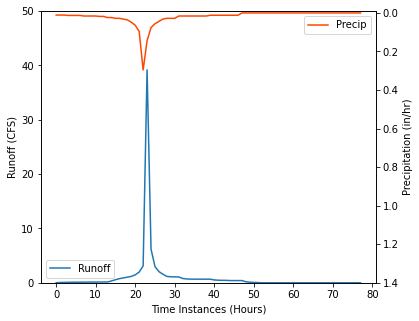

In [71]:
fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73081['Runoff (CFS)']); plt.ylim((-0.001,50)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73081['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72671

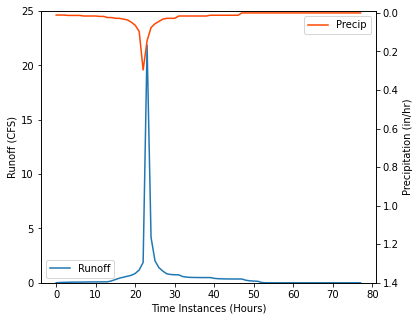

In [72]:
# This is for your Subcatchment 72671
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72671 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 5829, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72671.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72671.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72671['Runoff (CFS)']); plt.ylim((-0.001,25)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72671['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72591

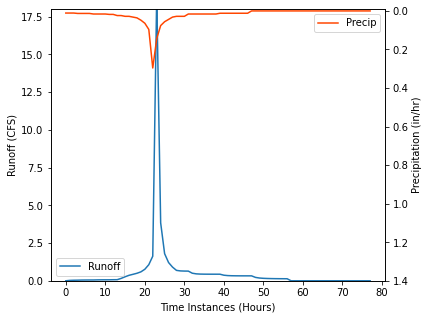

In [73]:
# This is for your Subcatchment 72591
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72591 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 5659, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72591.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72591.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72591['Runoff (CFS)']); plt.ylim((-0.001,18)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72591['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72631

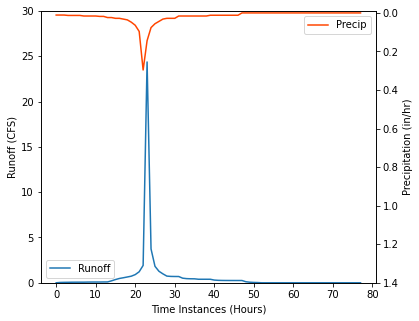

In [74]:
# This is for your Subcatchment 72631
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72631 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 5744, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72631.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72631.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72631['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72631['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72781

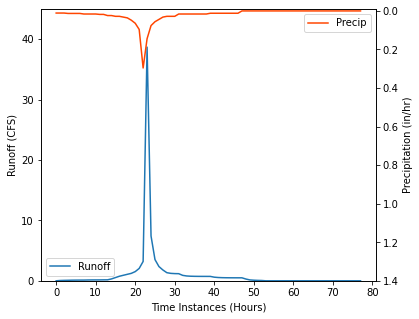

In [75]:
# This is for your Subcatchment 72781
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72781 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 5999, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72781.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72781.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72781['Runoff (CFS)']); plt.ylim((-0.001,45)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72781['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72731

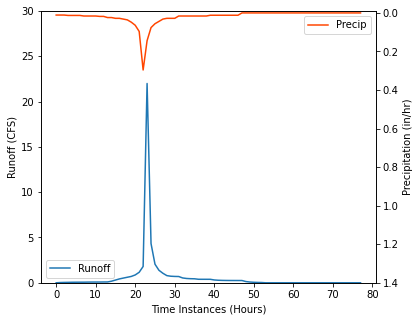

In [76]:
# This is for your Subcatchment 72731
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72731 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 5914, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72731.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72731.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72731['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72731['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72951

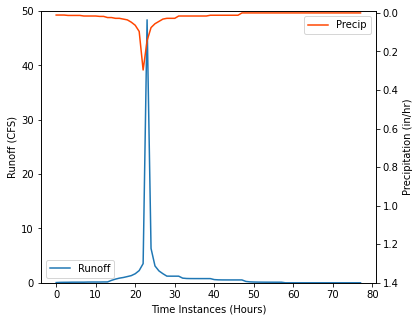

In [77]:
# This is for your Subcatchment 72951
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72951 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6169, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72951.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72951.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72951['Runoff (CFS)']); plt.ylim((-0.001,50)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72951['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');


## Subcatchment 73211

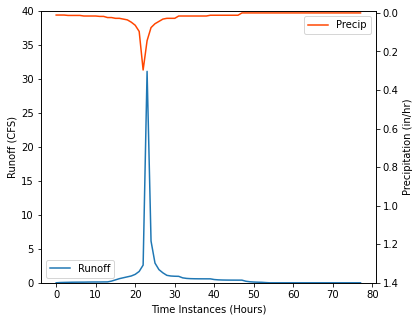

In [78]:
# This is for your Subcatchment 73211
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73211 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6764, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73211.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73211.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73211['Runoff (CFS)']); plt.ylim((-0.001,40)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73211['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73181

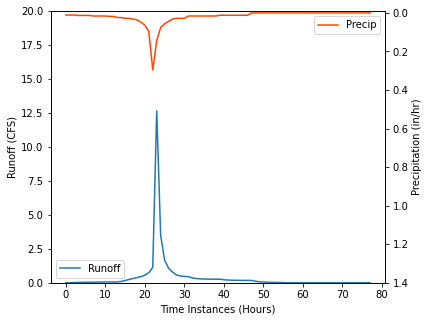

In [79]:
# This is for your Subcatchment 73181
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73181 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6594, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73181.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73181.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73181['Runoff (CFS)']); plt.ylim((-0.001,20)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73181['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73171

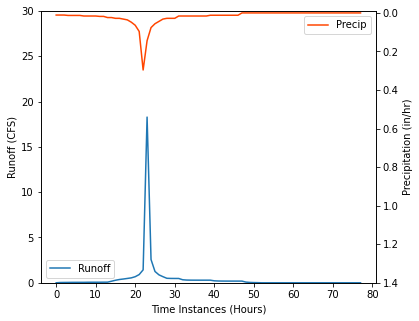

In [80]:
# This is for your Subcatchment 73171
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73171 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6509, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73171.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73171.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73171['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73171['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73121

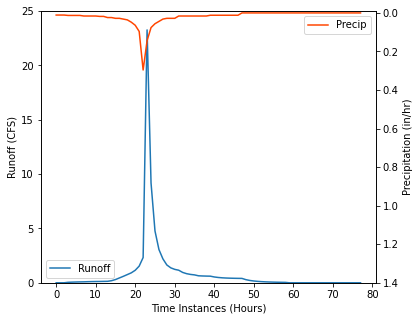

In [81]:
# This is for your Subcatchment 73121
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73121 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6424, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73121.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73121.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73121['Runoff (CFS)']); plt.ylim((-0.001,25)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73121['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73201

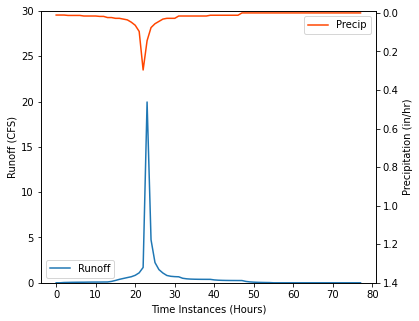

In [82]:
# This is for your Subcatchment 73201
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73201 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6679, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73201.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73201.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73201['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73201['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73301

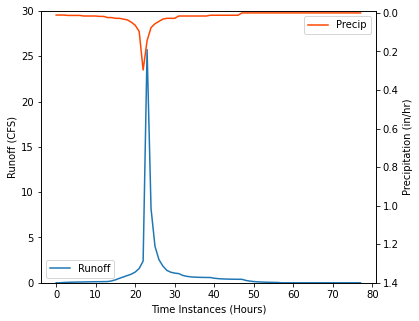

In [83]:
## This is for your Subcatchment 73301
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73301 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6934, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73301.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73301.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73301['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73301['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73321

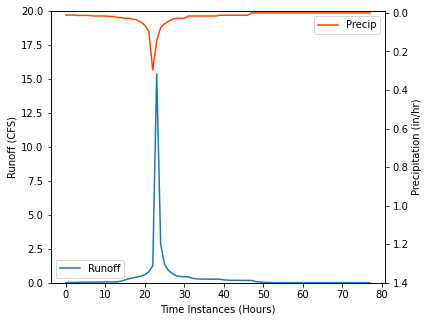

In [84]:
# This is for your Subcatchment 73321
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73321 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7019, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73321.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73321.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73321['Runoff (CFS)']); plt.ylim((-0.001,20)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73321['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73391

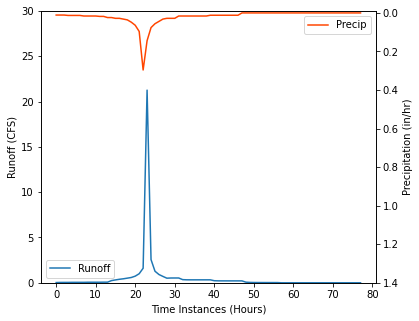

In [85]:
# This is for your Subcatchment 73391
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73391 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7189, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73391.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73391.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73391['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73391['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73551

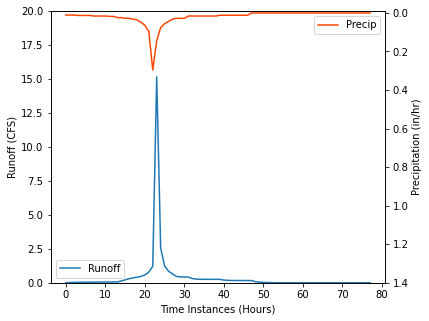

In [86]:
# This is for your Subcatchment 73551
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73551 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7699, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73551.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73551.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73551['Runoff (CFS)']); plt.ylim((-0.001,20)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73551['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73421

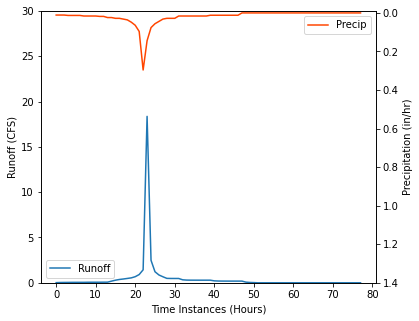

In [87]:
# This is for your Subcatchment 73421
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73421 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7359, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73421.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73421.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73421['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73421['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73531

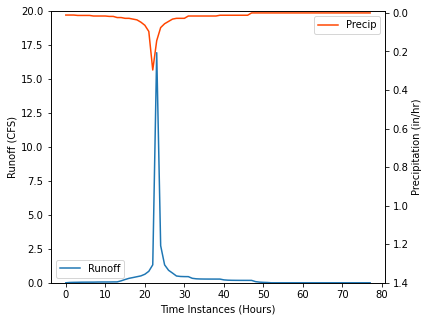

In [88]:
# This is for your Subcatchment 73531
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73531 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7614, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73531.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73531.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73531['Runoff (CFS)']); plt.ylim((-0.001,20)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73531['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

In [89]:
rpt_73531.max()

Date                        01/02/2000 15:00:00
Precip (in/hr)                            0.296
Losses (in/hr)                            0.004
Runoff (CFS)                            16.9323
Total Nitrogen (mg/L)                     1.154
Total Phosphorous (mg/L)                  0.299
dtype: object

## Subcatchment 73571

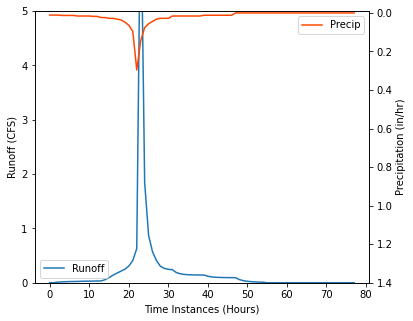

In [90]:
# This is for your Subcatchment 73571
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73571 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7784, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73571.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73571.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73571['Runoff (CFS)']); plt.ylim((-0.001,5)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73571['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73461

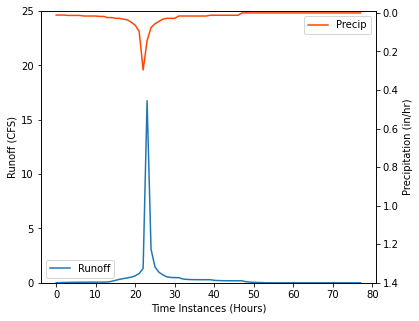

In [91]:
# This is for your Subcatchment 73461
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73461 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7444, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73461.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73461.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)


fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73461['Runoff (CFS)']); plt.ylim((-0.001,25)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73461['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');


In [92]:
rpt_73461

,Date,Precip (in/hr),Losses (in/hr),Runoff (CFS),Total Nitrogen (mg/L),Total Phosphorous (mg/L)
0,01/01/2000 00:30:00,0.011,0.0,0.0000,0.000,0.000
1,01/01/2000 01:00:00,0.011,0.0,0.0203,1.173,0.303
2,01/01/2000 01:30:00,0.011,0.0,0.0296,1.213,0.313
3,01/01/2000 02:00:00,0.013,0.0,0.0354,1.228,0.317
4,01/01/2000 02:30:00,0.013,0.0,0.0425,1.230,0.317
...,...,...,...,...,...,...
73,01/02/2000 13:00:00,0.000,0.0,0.0000,0.000,0.000
74,01/02/2000 13:30:00,0.000,0.0,0.0000,0.000,0.000
75,01/02/2000 14:00:00,0.000,0.0,0.0000,0.000,0.000
76,01/02/2000 14:30:00,0.000,0.0,0.0000,0.000,0.000


# Outflow near MC7 (In stream, near outlet of SWMM Model)


### No LID Scenario for Comparison
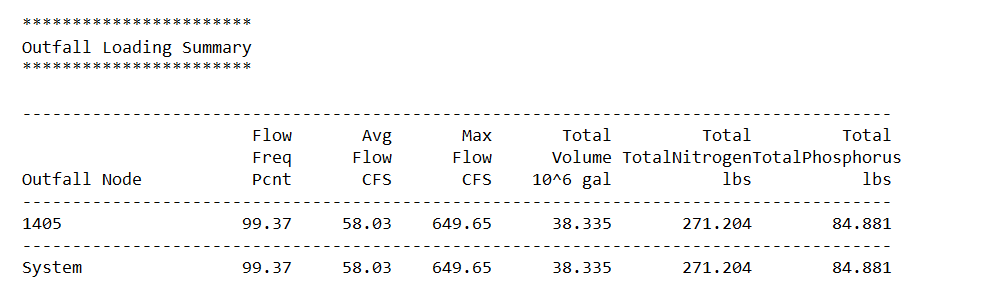

In [93]:
# Outfall
reportColumns = [str(i) for i in np.arange(0,15)]
rpt_1405 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 37646, nrows = 1, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_1405.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_1405.rename(columns = {'0':'Outfall Node','6':'Flow Freq %','7':'Avg Flow (CFS)','8':'Max Flow (CFS)','10':'Total Volume (10^6 Gallons)','12':'Total Nitrogen Load (lbs)','14':'Total Phosphorous (lbs)'},inplace = True)

In [94]:
rpt_1405.head()

,Outfall Node,Flow Freq %,Avg Flow (CFS),Max Flow (CFS),Total Volume (10^6 Gallons),Total Nitrogen Load (lbs),Total Phosphorous (lbs)
0,1405,99.37,57.4,637.58,37.998,267.127,83.726
